## Pipeline de Dados: UNSW-NB15 - EDA

Este notebook faz parte do projeto avaliativo da disciplina de Tópicos Computacionais em Ciência de Dados. O intuito deste projeto é realizar um Pipeline completo de dados, indo do carregamento dos dados até a avaliação dos resultados de modelagem dos dataset do **UNSW-BN15**.

Este notebook é responsável pelo tratamento inicial e EDA dos dados.

Para esse Pipeline se adotou os dados de treino e teste disponibilizado repósitorio, que pode ser acessado neste [link aqui](https://research.unsw.edu.au/projects/unsw-nb15-dataset).

### Sumário
1. Importações e Funções
2. Leitura dos dados
3. Transformações Iniciais
4. Sanity
5. Análises Exploratórias

**Desenvolvido por**
- Yago Aquino
- yagopacheco.34@gmail.com

## 1. Importações e Funções

Nesta seção vamos realizar a importações das bibliotecas e funções usadas ao longo do EDA.

In [1]:
import os
import re
import warnings
import zipfile

import numpy as np
import pandas as pd

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px

from scipy.stats import chi2_contingency

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.6f}'.format)
warnings.filterwarnings('ignore')

# Se for rodar local no jupyter ou vscode
# import plotly.io as pio
# import plotly.offline as pyo
# pio.renderers.default = "notebook"
# pyo.init_notebook_mode(connected=True)

### 1.1 Funções

In [2]:
def avalia_valores_nulos(df, tamanho_df):
    new_df = df.isna().sum().to_frame().rename(columns={0: 'QTD_NULOS'})
    new_df['%_NULOS'] = round(new_df['QTD_NULOS'] / tamanho_df * 100, 2)
    new_df = new_df[new_df['%_NULOS'] > 0].sort_values('%_NULOS', )

    return new_df


def qtd_unicos_coluna(df, col, top_5=False):
    '''
    Função para pegar a quantidade de cada
    valor único em uma coluna.
    '''
    contagem = df[col].value_counts()
    id_mais_frequente = contagem.index[0]
    frequencia = contagem.iloc[0]

    if top_5:
        return contagem.head()
    else:
        return f"O ID que mais se repete é {id_mais_frequente}, aparecendo {frequencia} vezes."


def avalia_valores_distintos(df, tamanho_df):
    distinct_counts = df.nunique().to_frame().rename(columns={0: 'QTD_DISTINTOS'})
    distinct_counts['%_DISTINTOS'] = round(distinct_counts['QTD_DISTINTOS'] / tamanho_df * 100, 2)
    distinct_counts = distinct_counts.sort_values('%_DISTINTOS', ascending=False)

    return distinct_counts


def obter_tab_freq(df, coluna, total=15):
  '''
  Função para obter a tabela de frequencia de uma coluna.
  '''
  # print("Tabela de frequencias")
  tam_df = df.shape[0]

  df = df[coluna].value_counts().to_frame().reset_index()
  df.columns = [coluna,'freq_absoluta']
  df['freq_relativa'] = round((df['freq_absoluta']/tam_df) * 100, 2)

  return df.head(total)


def barplot(df, x, y, xlab=None, ylab=None, title=None, order_desc=False, figsize=(8, 6)):
  if order_desc:
      df_sorted = df.sort_values(by=y, ascending=False)
      order = df_sorted[x].tolist()
  else:
      order = None

  fig, ax = plt.subplots(figsize=figsize)
  bar = sns.barplot(df, x=x, y=y, ax=ax, order=order)

  bars = bar.containers[0]
  bar_qtd = [rect.get_height() for rect in bars]
  labels = [f'{v:.0f} ({v/(sum(bar_qtd)):.1%})' for v in bar_qtd]
  ax.bar_label(bars, labels=labels, padding=5)

  sns.despine(offset=10)
  ax.set_title(title)
  ax.set_xlabel(xlab)
  ax.set_ylabel(ylab);


def plot_stacked_bar_100(df, coluna_1='class_label', coluna_2='conn_state', title=None, xlab=None, ylab=None, figsize=(10, 6)):
  crosstab = pd.crosstab(df[coluna_1], df[coluna_2])
  crosstab_pct = crosstab.div(crosstab.sum(axis=1), axis=0) * 100

  fig, ax = plt.subplots(figsize=figsize)

  crosstab_pct.plot(kind='bar', stacked=True, ax=ax, colormap='Set3', width=0.7)

  ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))
  ax.set_ylim(0, 100)

  ax.set_title(title, fontsize=14, pad=20)
  ax.set_xlabel(xlab, fontsize=12)
  ax.set_ylabel(ylab, fontsize=12)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

  ax.legend(title=coluna_2, bbox_to_anchor=(1.05, 1), loc='upper left')
  sns.despine()
  plt.tight_layout()

  return fig, ax


def box_plot(df, x, y, xlab=None, ylab=None, figsize=(12,6), ylim=None, hue=None, palette=None, color='lightskyblue', x_rotation=None):

  plt.figure(figsize=figsize)

  boxplot_params = {
      'data': df,
      'x': x,
      'y': y,
      'flierprops': {
          'marker': 'o',
          'markersize': 4
      }
  }

  if hue is not None:
      boxplot_params['hue'] = hue

      if palette is not None:
          boxplot_params['palette'] = palette
  else:
      boxplot_params['color'] = color

  ax = sns.boxplot(**boxplot_params)

  if ylim:
      plt.ylim(ylim)

  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)

  plt.suptitle('')
  plt.xlabel(xlab)
  plt.ylabel(ylab)

  plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))

  if x_rotation is not None:
      plt.xticks(rotation=x_rotation)

      if x_rotation >= 45:
          plt.xticks(rotation=x_rotation, ha='right')

  if hue is not None:
      plt.legend(title=hue)

  plt.show()


def df_outliers(df, coluna, outlier=True):
  q1 = df[coluna].quantile(0.25)
  q3 = df[coluna].quantile(0.75)

  iqr = q3 - q1

  limite_inf = q1 - 1.5 * iqr
  limite_sup = q3 + 1.5 * iqr

  if outlier:
      df_com_outlier = df[(df[coluna] < limite_inf) | (df[coluna] > limite_sup)]

      print(f'Número de outliers: {len(df_com_outlier)}')
      print(f'\nLimite inferior: {limite_inf:.2f}')
      print(f'Limite superior: {limite_sup:.2f}')

      return df_com_outlier
  else:
      df_sem_outlier = df[(df[coluna] >= limite_inf) & (df[coluna] <= limite_sup)]
      return df_sem_outlier


def plot_chi2_heatmap(df, title="Contingency Coefficient Analysis for Each Nominal Variable"):

  def chi2_analysis(variable1, variable2):
      if variable1.equals(variable2):
          return 1.0

      contingency_table = pd.crosstab(variable1, variable2)
      chi2, p_value, _, _ = chi2_contingency(contingency_table)
      n = contingency_table.values.sum()
      contingency_coef = np.sqrt(chi2 / (chi2 + n))

      return contingency_coef

  variables = df.columns.tolist()
  n_variables = len(variables)

  df_matrix = np.zeros((n_variables, n_variables))

  for i in range(n_variables):
      for j in range(n_variables):
          if i == j:
              df_matrix[i, j] = 1.0
          else:
              result = chi2_analysis(df[variables[i]], df[variables[j]])
              df_matrix[i, j] = result

  category_bounds = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
  categories = ['Muito Fraca', 'Fraca', 'Moderada', 'Forte', 'Muito Forte']

  df_heatmap = pd.DataFrame(df_matrix,
                            index=variables,
                            columns=variables)

  colors = sns.color_palette('coolwarm', len(categories))
  cmap = ListedColormap(colors)

  fig, ax = plt.subplots(figsize=(12, 10))

  sns.heatmap(df_heatmap,
              cmap=cmap,
              fmt=".3f",
              cbar=False,
              ax=ax,
              linewidths=1,
              linecolor='white',
              vmin=0,
              vmax=1,
              annot=True,
              square=True)

  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

  ax.set_title(title, fontsize=14, pad=20)

  legend_labels = [f'{category}: {category_bounds[i]:.1f} - {category_bounds[i+1]:.1f}'
                    for i, category in enumerate(categories)]
  legend_elements = [plt.Rectangle((0, 0), 1, 1, fc=colors[i])
                    for i in range(len(categories))]

  legend_elements = legend_elements[::-1]
  legend_labels = legend_labels[::-1]

  ax.legend(handles=legend_elements,
            labels=legend_labels,
            loc='center left',
            bbox_to_anchor=(1.02, 0.5),
            title='Força da correlação')

  plt.tight_layout()
  plt.show()

  return df_heatmap


def remocao_colunas_corr(df, target_col, corr_threshold=0.9, target_corr_range=(-0.1, 0.1), method='spearman'):
  features = df.drop(columns=[target_col])
  target = df[target_col]

  corr_matrix = features.corr(method=method).abs()
  target_corr = features.corrwith(target, method=method).abs()

  upper_tri = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)

  high_corr_pairs = np.where((corr_matrix.values > corr_threshold) & upper_tri)

  columns_to_remove = set()

  for i, j in zip(high_corr_pairs[0], high_corr_pairs[1]):
      col_i = corr_matrix.columns[i]
      col_j = corr_matrix.columns[j]

      corr_i_target = target_corr[col_i]
      corr_j_target = target_corr[col_j]

      if target_corr_range[0] <= corr_i_target <= target_corr_range[1]:
          columns_to_remove.add(col_i)
      elif target_corr_range[0] <= corr_j_target <= target_corr_range[1]:
          columns_to_remove.add(col_j)
      elif corr_i_target < corr_j_target:
          columns_to_remove.add(col_i)
      else:
          columns_to_remove.add(col_j)

  df_filtered = df.drop(columns=list(columns_to_remove))

  print(f"Colunas removidas: {len(columns_to_remove)}")
  print(f"Colunas restantes: {len(df_filtered.columns)}")

  return df_filtered, list(columns_to_remove)

## 2. Leitura dos dados

Nesta seção vamos realizar a leitura dos dados.

In [3]:
# Extração dos arquivos
with zipfile.ZipFile('/content/unsw_data.zip', 'r') as zip_file:
    arquivos = zip_file.namelist()
    print("Arquivos no ZIP:", arquivos, '\n')

    df_test = pd.read_csv(zip_file.open(arquivos[1]))
    df = pd.read_csv(zip_file.open(arquivos[2]))

print(f"\nTreino: {df.shape}")
display(df.head())

print(f"\nTeste: {df_test.shape}")
display(df_test.head())

Arquivos no ZIP: ['unsw_data/', 'unsw_data/UNSW_NB15_testing-set.csv', 'unsw_data/UNSW_NB15_training-set.csv'] 


Treino: (175341, 45)


id      dur proto service state  spkts  dpkts  sbytes  dbytes      rate  \
0   1 0.121478   tcp       -   FIN      6      4     258     172 74.087490   
1   2 0.649902   tcp       -   FIN     14     38     734   42014 78.473372   
2   3 1.623129   tcp       -   FIN      8     16     364   13186 14.170161   
3   4 1.681642   tcp     ftp   FIN     12     12     628     770 13.677108   
4   5 0.449454   tcp       -   FIN     10      6     534     268 33.373826   

   sttl  dttl        sload         dload  sloss  dloss     sinpkt     dinpkt  \
0   252   254 14158.942380   8495.365234      0      0  24.295600   8.375000   
1    62   252  8395.112305 503571.312500      2     17  49.915000  15.432865   
2    62   252  1572.271851  60929.230470      1      6 231.875571 102.737203   
3    62   252  2740.178955   3358.622070      1      3 152.876547  90.235726   
4   254   252  8561.499023   3987.059814      2      1  47.750333  75.659602   

          sjit         djit  swin       stcpb       dtcpb  dwin   tcprtt  \
0    30.177547    11.830604   255   621772692  2202533631   255 0.000000   
1    61.426934  1387.778330   255  1417884146  3077387971   255 0.000000   
2 17179.586860 11420.926230   255  2116150707  2963114973   255 0.111897   
3   259.080172  4991.784669   255  1107119177  1047442890   255 0.000000   
4  2415.837634   115.807000   255  2436137549  1977154190   255 0.128381   

    synack   ackdat  smean  dmean  trans_depth  response_body_len  ct_srv_src  \
0 0.000000 0.000000     43     43            0                  0           1   
1 0.000000 0.000000     52   1106            0                  0          43   
2 0.061458 0.050439     46    824            0                  0           7   
3 0.000000 0.000000     52     64            0                  0           1   
4 0.071147 0.057234     53     45            0                  0          43   

   ct_state_ttl  ct_dst_ltm  ct_src_dport_ltm  ct_dst_sport_ltm  \
0             0           1                 1                 1   
1             1           1                 1                 1   
2             1           2                 1                 1   
3             1           2                 1                 1   
4             1           2                 2                 1   

   ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  ct_flw_http_mthd  ct_src_ltm  \
0               1             0           0                 0           1   
1               2             0           0                 0           1   
2               3             0           0                 0           2   
3               3             1           1                 0           2   
4              40             0           0                 0           2   

   ct_srv_dst  is_sm_ips_ports attack_cat  label  
0           1                0     Normal      0  
1           6                0     Normal      0  
2           6                0     Normal      0  
3           1                0     Normal      0  
4          39                0     Normal      0


Teste: (82332, 45)


id      dur proto service state  spkts  dpkts  sbytes  dbytes  \
0   1 0.000011   udp       -   INT      2      0     496       0   
1   2 0.000008   udp       -   INT      2      0    1762       0   
2   3 0.000005   udp       -   INT      2      0    1068       0   
3   4 0.000006   udp       -   INT      2      0     900       0   
4   5 0.000010   udp       -   INT      2      0    2126       0   

           rate  sttl  dttl            sload    dload  sloss  dloss   sinpkt  \
0  90909.090200   254     0 180363632.000000 0.000000      0      0 0.011000   
1 125000.000300   254     0 881000000.000000 0.000000      0      0 0.008000   
2 200000.005100   254     0 854400000.000000 0.000000      0      0 0.005000   
3 166666.660800   254     0 600000000.000000 0.000000      0      0 0.006000   
4 100000.002500   254     0 850400000.000000 0.000000      0      0 0.010000   

    dinpkt     sjit     djit  swin  stcpb  dtcpb  dwin   tcprtt   synack  \
0 0.000000 0.000000 0.000000     0      0      0     0 0.000000 0.000000   
1 0.000000 0.000000 0.000000     0      0      0     0 0.000000 0.000000   
2 0.000000 0.000000 0.000000     0      0      0     0 0.000000 0.000000   
3 0.000000 0.000000 0.000000     0      0      0     0 0.000000 0.000000   
4 0.000000 0.000000 0.000000     0      0      0     0 0.000000 0.000000   

    ackdat  smean  dmean  trans_depth  response_body_len  ct_srv_src  \
0 0.000000    248      0            0                  0           2   
1 0.000000    881      0            0                  0           2   
2 0.000000    534      0            0                  0           3   
3 0.000000    450      0            0                  0           3   
4 0.000000   1063      0            0                  0           3   

   ct_state_ttl  ct_dst_ltm  ct_src_dport_ltm  ct_dst_sport_ltm  \
0             2           1                 1                 1   
1             2           1                 1                 1   
2             2           1                 1                 1   
3             2           2                 2                 1   
4             2           2                 2                 1   

   ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  ct_flw_http_mthd  ct_src_ltm  \
0               2             0           0                 0           1   
1               2             0           0                 0           1   
2               3             0           0                 0           1   
3               3             0           0                 0           2   
4               3             0           0                 0           2   

   ct_srv_dst  is_sm_ips_ports attack_cat  label  
0           2                0     Normal      0  
1           2                0     Normal      0  
2           3                0     Normal      0  
3           3                0     Normal      0  
4           3                0     Normal      0

## 3. Transformações Iniciais

Nesta seção serão aplicadas transformações com o intuito de diminuir o tamanho do dataset, no caso alterando a sua tipagem e quando possivel removendo colunas totalmente nulas.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 175341 non-null  int64  
 1   dur                175341 non-null  float64
 2   proto              175341 non-null  object 
 3   service            175341 non-null  object 
 4   state              175341 non-null  object 
 5   spkts              175341 non-null  int64  
 6   dpkts              175341 non-null  int64  
 7   sbytes             175341 non-null  int64  
 8   dbytes             175341 non-null  int64  
 9   rate               175341 non-null  float64
 10  sttl               175341 non-null  int64  
 11  dttl               175341 non-null  int64  
 12  sload              175341 non-null  float64
 13  dload              175341 non-null  float64
 14  sloss              175341 non-null  int64  
 15  dloss              175341 non-null  int64  
 16  si

In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  int64  
 6   dpkts              82332 non-null  int64  
 7   sbytes             82332 non-null  int64  
 8   dbytes             82332 non-null  int64  
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  int64  
 11  dttl               82332 non-null  int64  
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  int64  
 15  dloss              82332 non-null  int64  
 16  sinpkt             823

No csv de feature é informado que o caracter "-" usado nas colunas com a tipagem de string é uma categoria nominal válida. No caso ele tem o seguinte significado:

- Para a característica state (estado), (-) significa "se o estado não for utilizado"
- Para a característica service (serviço), (-) significa "se não for um serviço muito utilizado"

Além disso, temos colunas de ids, que podem ser problemas pelo fato delas causarem data leakage. Pois, vai conter o id do atacante e como a gente quer generalizar o nosso modelo, são colunas que não fazem sentido manter em nosso dataset. Vamos fazer essa remoção em seções posteriores.

## 4. Sanity

Nesta seção vamos verificar a sanidade dos dados e suas caracteristicas básicas.

In [6]:
avalia_valores_nulos(df, df.shape[0])

Empty DataFrame
Columns: [QTD_NULOS, %_NULOS]
Index: []

In [7]:
avalia_valores_nulos(df_test, df.shape[0])

Empty DataFrame
Columns: [QTD_NULOS, %_NULOS]
Index: []

In [8]:
avalia_valores_distintos(df, df.shape[0])

QTD_DISTINTOS  %_DISTINTOS
id                        175341   100.000000
sload                      80885    46.130000
sjit                       77532    44.220000
dload                      77474    44.180000
rate                       76991    43.910000
djit                       76831    43.820000
sinpkt                     76161    43.440000
stcpb                      75265    42.920000
dtcpb                      75089    42.820000
dinpkt                     74245    42.340000
dur                        74039    42.230000
tcprtt                     43319    24.710000
synack                     40142    22.890000
ackdat                     37708    21.510000
sbytes                      7214     4.110000
dbytes                      6660     3.800000
response_body_len           2386     1.360000
smean                       1357     0.770000
dmean                       1328     0.760000
spkts                        480     0.270000
dpkts                        443     0.250000
sloss                        409     0.230000
dloss                        370     0.210000
proto                        133     0.080000
ct_dst_ltm                    50     0.030000
ct_dst_src_ltm                54     0.030000
ct_src_ltm                    50     0.030000
ct_src_dport_ltm              47     0.030000
ct_srv_src                    52     0.030000
ct_srv_dst                    52     0.030000
ct_dst_sport_ltm              32     0.020000
service                       13     0.010000
state                          9     0.010000
ct_flw_http_mthd              11     0.010000
sttl                          11     0.010000
attack_cat                    10     0.010000
swin                          13     0.010000
trans_depth                   11     0.010000
dttl                           6     0.000000
dwin                           7     0.000000
ct_state_ttl                   5     0.000000
is_ftp_login                   4     0.000000
ct_ftp_cmd                     4     0.000000
is_sm_ips_ports                2     0.000000
label                          2     0.000000

In [9]:
df.columns

Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')

In [10]:
# Verificando se temos duplicatas
df.duplicated().sum(), df_test.duplicated().sum()

(np.int64(0), np.int64(0))

In [11]:
drop_describe = ['id', 'is_ftp_login', 'is_sm_ips_ports', 'label']
df.drop(drop_describe, axis=1).describe().T

count             mean               std       min  \
dur               175341.000000         1.359389          6.480249  0.000000   
spkts             175341.000000        20.298664        136.887597  1.000000   
dpkts             175341.000000        18.969591        110.258271  0.000000   
sbytes            175341.000000      8844.843836     174765.644309 28.000000   
dbytes            175341.000000     14928.918564     143654.217718  0.000000   
rate              175341.000000     95406.187105     165400.978457  0.000000   
sttl              175341.000000       179.546997        102.940011  0.000000   
dttl              175341.000000        79.609567        110.506863  0.000000   
sload             175341.000000  73454033.194063  188357447.000193  0.000000   
dload             175341.000000    671205.574188    2421312.388763  0.000000   
sloss             175341.000000         4.953000         66.005059  0.000000   
dloss             175341.000000         6.948010         52.732999  0.000000   
sinpkt            175341.000000       985.976864       7242.245841  0.000000   
dinpkt            175341.000000        88.216296        987.093195  0.000000   
sjit              175341.000000      4976.254226      44965.846519  0.000000   
djit              175341.000000       604.353826       4061.043281  0.000000   
swin              175341.000000       116.257339        127.001024  0.000000   
stcpb             175341.000000 969250421.910511 1355264249.263931  0.000000   
dtcpb             175341.000000 968877027.071153 1353999546.225313  0.000000   
dwin              175341.000000       115.013625        126.886530  0.000000   
tcprtt            175341.000000         0.041396          0.079354  0.000000   
synack            175341.000000         0.021020          0.043400  0.000000   
ackdat            175341.000000         0.020375          0.040506  0.000000   
smean             175341.000000       136.751769        204.677360 28.000000   
dmean             175341.000000       124.173382        258.317056  0.000000   
trans_depth       175341.000000         0.105982          0.776911  0.000000   
response_body_len 175341.000000      2144.291655      54207.967294  0.000000   
ct_srv_src        175341.000000         9.306437         10.704331  1.000000   
ct_state_ttl      175341.000000         1.304179          0.954406  0.000000   
ct_dst_ltm        175341.000000         6.193936          8.052476  1.000000   
ct_src_dport_ltm  175341.000000         5.383538          8.047104  1.000000   
ct_dst_sport_ltm  175341.000000         4.206255          5.783585  1.000000   
ct_dst_src_ltm    175341.000000         8.729881         10.956186  1.000000   
ct_ftp_cmd        175341.000000         0.014948          0.126048  0.000000   
ct_flw_http_mthd  175341.000000         0.133066          0.701208  0.000000   
ct_src_ltm        175341.000000         6.955789          8.321493  1.000000   
ct_srv_dst        175341.000000         9.100758         10.756952  1.000000   

                           25%           50%               75%  \
dur                   0.000008      0.001582          0.668069   
spkts                 2.000000      2.000000         12.000000   
dpkts                 0.000000      2.000000         10.000000   
sbytes              114.000000    430.000000       1418.000000   
dbytes                0.000000    164.000000       1102.000000   
rate                 32.786140   3225.806520     125000.000300   
sttl                 62.000000    254.000000        254.000000   
dttl                  0.000000     29.000000        252.000000   
sload             13053.338870 879674.750000   88888888.000000   
dload                 0.000000   1447.022705      27844.871090   
sloss                 0.000000      0.000000          3.000000   
dloss                 0.000000      0.000000          2.000000   
sinpkt                0.008000      0.279733         55.156896   
dinpkt                0.000000      0.006000         51.05300

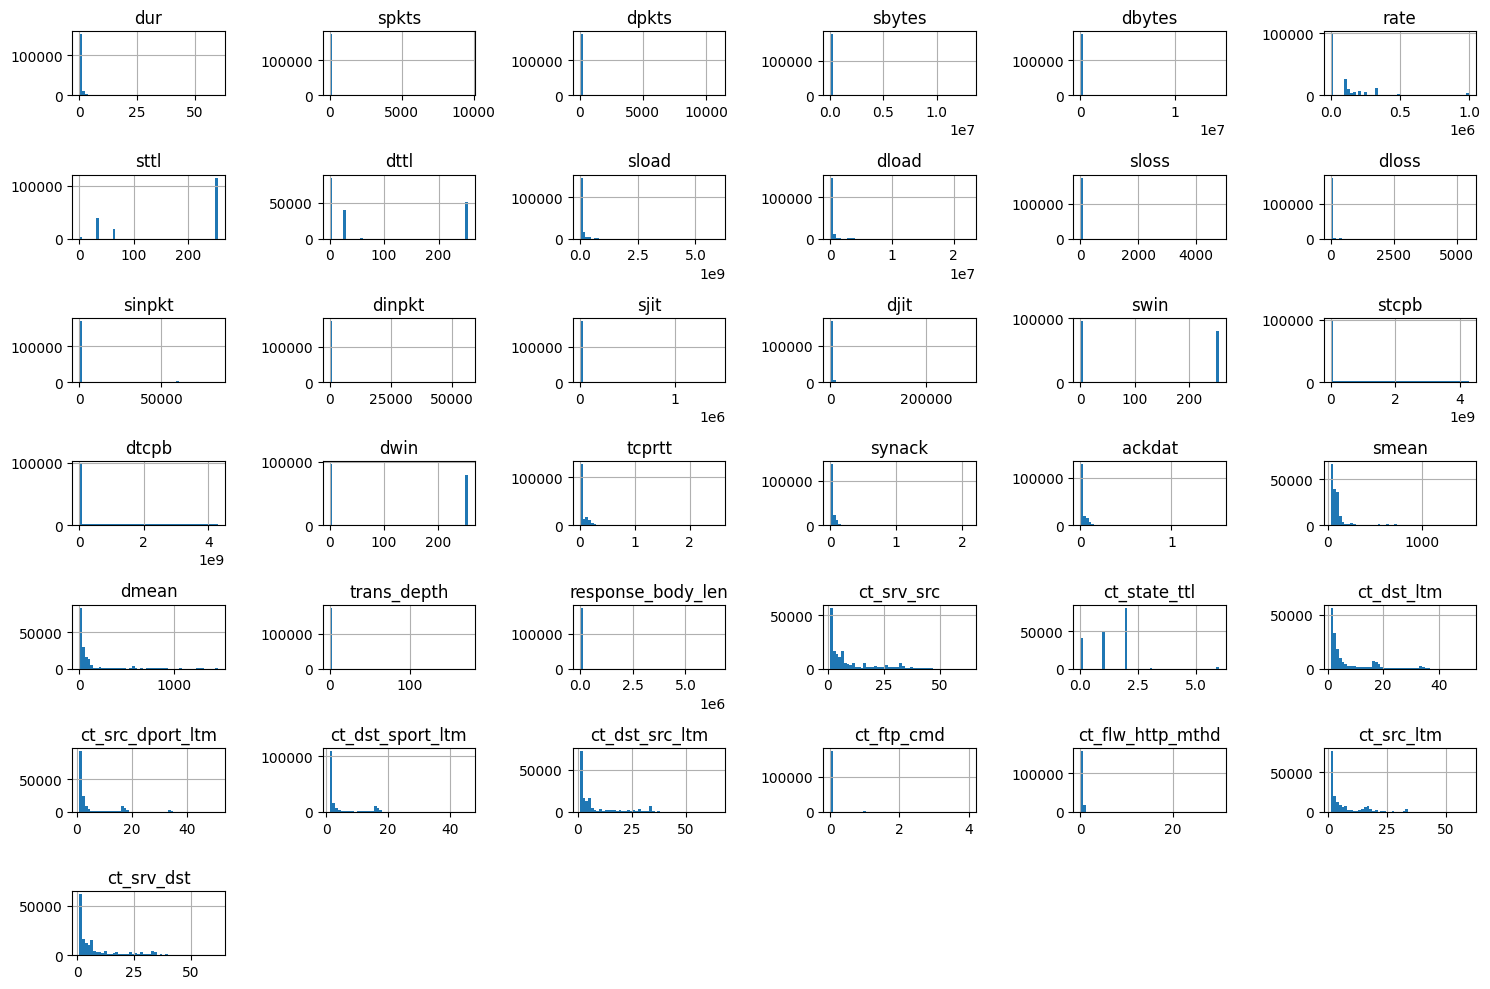

In [12]:
df.drop(drop_describe, axis=1).hist(figsize=(15, 10), bins=50)
plt.tight_layout()
plt.show()

In [13]:
colunas_cat = [
    'proto', 'service', 'state', 'attack_cat',
    'label'
]

for col in colunas_cat:
  print("===" * 20, f"{col}", "===" * 20)
  display(obter_tab_freq(df, col))
  print("\n")

============================================================ proto ============================================================


proto  freq_absoluta  freq_relativa
0      tcp          79946      45.590000
1      udp          63283      36.090000
2     unas          12084       6.890000
3      arp           2859       1.630000
4     ospf           2595       1.480000
5     sctp           1150       0.660000
6      any            300       0.170000
7      gre            225       0.130000
8     ipv6            201       0.110000
9   mobile            201       0.110000
10     pim            201       0.110000
11   swipe            201       0.110000
12  sun-nd            201       0.110000
13    rsvp            200       0.110000
14     sep            193       0.110000



============================================================ service ============================================================


service  freq_absoluta  freq_relativa
0          -          94168      53.710000
1        dns          47294      26.970000
2       http          18724      10.680000
3       smtp           5058       2.880000
4   ftp-data           3995       2.280000
5        ftp           3428       1.960000
6        ssh           1302       0.740000
7       pop3           1105       0.630000
8       dhcp             94       0.050000
9       snmp             80       0.050000
10       ssl             56       0.030000
11       irc             25       0.010000
12    radius             12       0.010000



============================================================ state ============================================================


state  freq_absoluta  freq_relativa
0   INT          82275      46.920000
1   FIN          77825      44.380000
2   CON          13152       7.500000
3   REQ           1991       1.140000
4   RST             83       0.050000
5   ECO             12       0.010000
6   PAR              1       0.000000
7   URN              1       0.000000
8    no              1       0.000000



============================================================ attack_cat ============================================================


attack_cat  freq_absoluta  freq_relativa
0          Normal          56000      31.940000
1         Generic          40000      22.810000
2        Exploits          33393      19.040000
3         Fuzzers          18184      10.370000
4             DoS          12264       6.990000
5  Reconnaissance          10491       5.980000
6        Analysis           2000       1.140000
7        Backdoor           1746       1.000000
8       Shellcode           1133       0.650000
9           Worms            130       0.070000



============================================================ label ============================================================


label  freq_absoluta  freq_relativa
0      1         119341      68.060000
1      0          56000      31.940000

In [14]:
for col in colunas_cat:
  print("===" * 20, f"{col}", "===" * 20)
  display(obter_tab_freq(df_test, col))
  print("\n")

============================================================ proto ============================================================


proto  freq_absoluta  freq_relativa
0      tcp          43095      52.340000
1      udp          29418      35.730000
2     unas           3515       4.270000
3      arp            987       1.200000
4     ospf            676       0.820000
5     sctp            324       0.390000
6      any             96       0.120000
7      gre             88       0.110000
8     rsvp             64       0.080000
9     ipv6             61       0.070000
10     sep             58       0.070000
11  sun-nd             54       0.070000
12   swipe             52       0.060000
13  mobile             52       0.060000
14     pim             52       0.060000



============================================================ service ============================================================


service  freq_absoluta  freq_relativa
0          -          47153      57.270000
1        dns          21367      25.950000
2       http           8287      10.070000
3       smtp           1851       2.250000
4        ftp           1552       1.890000
5   ftp-data           1396       1.700000
6       pop3            423       0.510000
7        ssh            204       0.250000
8        ssl             30       0.040000
9       snmp             29       0.040000
10      dhcp             26       0.030000
11    radius              9       0.010000
12       irc              5       0.010000



============================================================ state ============================================================


state  freq_absoluta  freq_relativa
0   FIN          39339      47.780000
1   INT          34163      41.490000
2   CON           6982       8.480000
3   REQ           1842       2.240000
4   ACC              4       0.000000
5   RST              1       0.000000
6   CLO              1       0.000000



============================================================ attack_cat ============================================================


attack_cat  freq_absoluta  freq_relativa
0          Normal          37000      44.940000
1         Generic          18871      22.920000
2        Exploits          11132      13.520000
3         Fuzzers           6062       7.360000
4             DoS           4089       4.970000
5  Reconnaissance           3496       4.250000
6        Analysis            677       0.820000
7        Backdoor            583       0.710000
8       Shellcode            378       0.460000
9           Worms             44       0.050000



============================================================ label ============================================================


label  freq_absoluta  freq_relativa
0      1          45332      55.060000
1      0          37000      44.940000

O principal ponto aqui é verificar que as classes de previsão de teste é muito mais desbalanceada do que a classe de treino. Enquanto a classe de treino os valores rotulados como tráfego maligno representa 68,1%% das linhas, em teste essa representação muda para 55,1%.

Com isso, se faz necessário já treinar o modelo pensando no desblanceamento. Uma outra alternativa, que pode ser trabalhada no final, caso e tenha tempo e rearranjar os conjuntos.

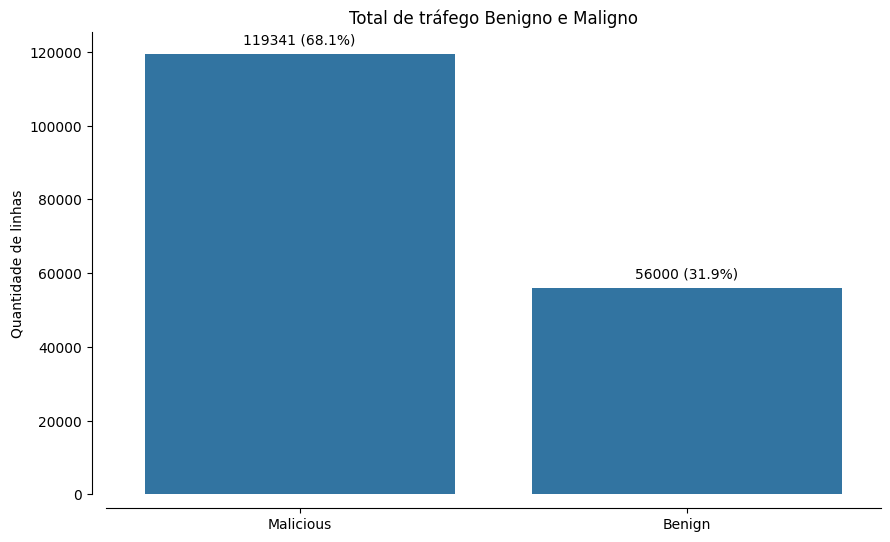

In [15]:
df_temp = df.copy()

df_temp['class_name'] = df_temp['label'].map({0: 'Benign', 1: 'Malicious'})

df_barplot = df_temp['class_name'].value_counts().to_frame().reset_index()

barplot(
    df_barplot,
    x='class_name',
    y='count',
    ylab="Quantidade de linhas",
    title="Total de tráfego Benigno e Maligno",
    order_desc=True,
    figsize=(10, 6)
)

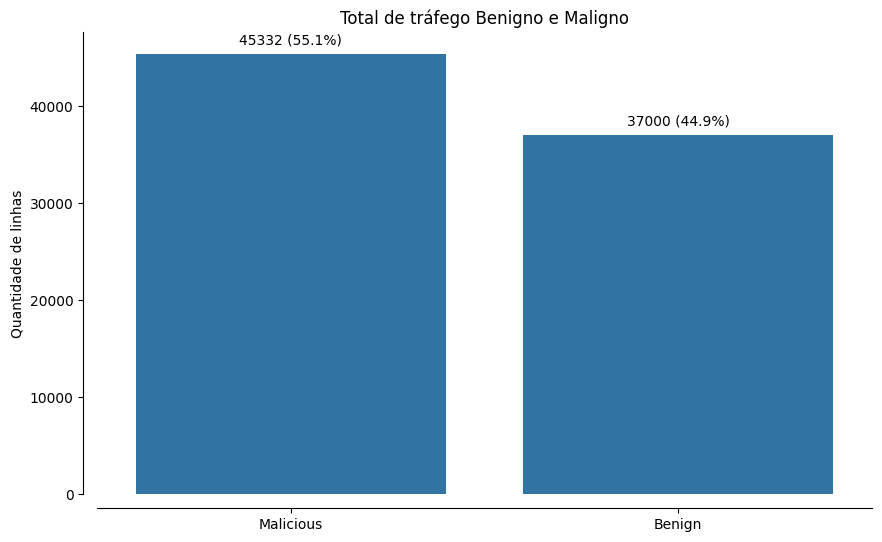

In [16]:
df_temp = df_test.copy()

df_temp['class_name'] = df_temp['label'].map({0: 'Benign', 1: 'Malicious'})

df_barplot = df_temp['class_name'].value_counts().to_frame().reset_index()

barplot(
    df_barplot,
    x='class_name',
    y='count',
    ylab="Quantidade de linhas",
    title="Total de tráfego Benigno e Maligno",
    order_desc=True,
    figsize=(10, 6)
)

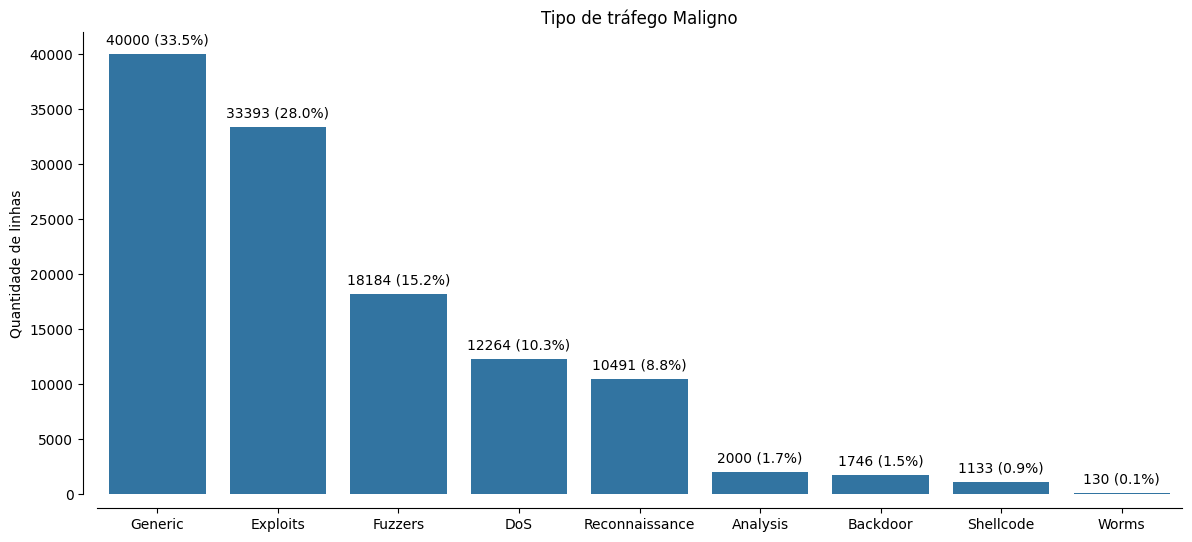

In [17]:
df_temp = df[df['label'] == 1].copy()
df_barplot = df_temp['attack_cat'].value_counts().to_frame().reset_index()

barplot(
    df_barplot,
    x='attack_cat',
    y='count',
    ylab="Quantidade de linhas",
    title="Tipo de tráfego Maligno",
    order_desc=True,
    figsize=(14, 6)
)

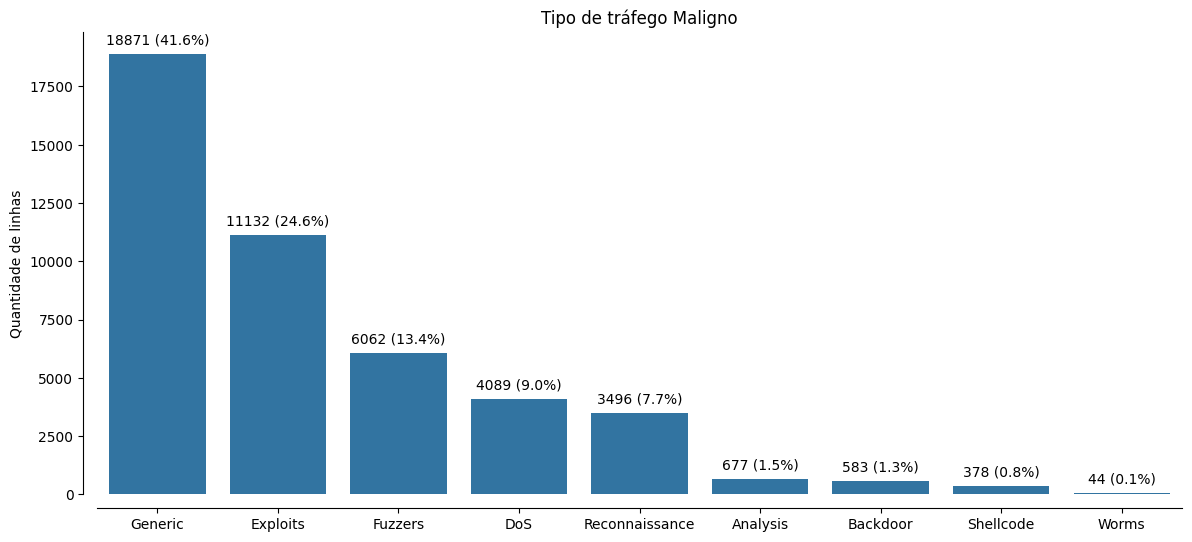

In [18]:
df_temp = df_test[df_test['label'] == 1].copy()
df_barplot = df_temp['attack_cat'].value_counts().to_frame().reset_index()

barplot(
    df_barplot,
    x='attack_cat',
    y='count',
    ylab="Quantidade de linhas",
    title="Tipo de tráfego Maligno",
    order_desc=True,
    figsize=(14, 6)
)

Quando olhamos para os dados maliciosos conseguimos notar a presença de 9 tipos de ataques, sendo o `Generic` o mais representativo, seguido do `Exploit`. Entretando, vamos tratar apenas como dados binários. Tráfego maligno e beningno. Conseguimos notar que essa mesma lógica segue para a base de testes, a diferença é que temos o `Exploit` mais representativo se comparar com a base de teste.

Para os demais itens que eram bools que foram removidos do describe, se optou por criar uma tabela em vez de um gráfico. Abaixo temos essas tabelas

In [19]:
display(df['is_ftp_login'].value_counts().reset_index())
print("\n")
display(df['is_sm_ips_ports'].value_counts().reset_index())

is_ftp_login   count
0             0  172774
1             1    2545
2             4      16
3             2       6

is_sm_ips_ports   count
0                0  172579
1                1    2762

- is_ftp_login: Se a sessão FTP for acessada por usuário e senha, então 1, caso contrário, 0 (binário). Em algusn casos temos o 2 e o 3 que quer dizer uma tenativa de login FTP que não foi completada.

- is_sm_ips_ports: Se os endereços IP de origem e destino forem iguais e os números das portas forem iguais, esta variável assume o valor 1, caso contrário, 0 (binário)

In [20]:
# Aplicar o tratamento para ficar só em 0 e 1
display(df_test['is_ftp_login'].value_counts().reset_index())
print("\n")
display(df_test['is_sm_ips_ports'].value_counts().reset_index())

is_ftp_login  count
0             0  81654
1             1    674
2             2      4

is_sm_ips_ports  count
0                0  81416
1                1    916

## 5. Análises Exploratórias

Quando olhamos os resultados, percebemos que temos muitas colunas para analisar, seja na parte da estatística descritiva seja a distribuição pelo histograma. Devido a isso, se optou por se separar 9 colunas que representam um "pilar" diferente da análise de tráfego, o que permite a gente ter uma visão completa do que está ocorrendo na rede por meio dessas colunas. Sendo elas:
- **dur** (duração): Em geral conexões curtas podem ser scans e longas malware
- **sbytes** e **dbytes** (volume de dados): Picos de volume indicam floods, exploits ou data exfiltration.
- **rate** (pacotes por segundo): A métrica principal para detectar ataques DDoS.
- **slood** (bits por segundo): Mede a "agressividade" e intensidade da transmissão.
- **sttl** (tempo de vida do pacote): Valores anômalos podem indicar spoofing ou fingerprinting.
- **smean** (tamanho médio do pacote): Diferencia ataques de pacotes pequenos (floods) de grandes (exploits)
- **ct_srv_dst** (conexões recentes ao mesmo serviço): Detecta DoS em serviços e port Scanning.
- **ct_dst_src_ltm** (conexões recentes entre o mesmo par): Detecta força bruta e atividade repetitivas de um atacante.

### 5.1 Distribuição geral

In [21]:
colunas_filter = [
    'dur', 'sbytes', 'dbytes', 'rate',
    'sttl', 'sload', 'smean', 'ct_srv_dst',
    'ct_dst_src_ltm'
]

df[colunas_filter].describe().T

count            mean              std       min  \
dur            175341.000000        1.359389         6.480249  0.000000   
sbytes         175341.000000     8844.843836    174765.644309 28.000000   
dbytes         175341.000000    14928.918564    143654.217718  0.000000   
rate           175341.000000    95406.187105    165400.978457  0.000000   
sttl           175341.000000      179.546997       102.940011  0.000000   
sload          175341.000000 73454033.194063 188357447.000193  0.000000   
smean          175341.000000      136.751769       204.677360 28.000000   
ct_srv_dst     175341.000000        9.100758        10.756952  1.000000   
ct_dst_src_ltm 175341.000000        8.729881        10.956186  1.000000   

                        25%           50%             75%               max  
dur                0.000008      0.001582        0.668069         59.999989  
sbytes           114.000000    430.000000     1418.000000   12965233.000000  
dbytes             0.000000    164.000000     1102.000000   14655550.000000  
rate              32.786140   3225.806520   125000.000300    1000000.003000  
sttl              62.000000    254.000000      254.000000        255.000000  
sload          13053.338870 879674.750000 88888888.000000 5988000256.000000  
smean             57.000000     73.000000      100.000000       1504.000000  
ct_srv_dst         2.000000      4.000000       12.000000         62.000000  
ct_dst_src_ltm     1.000000      3.000000       12.000000         65.000000

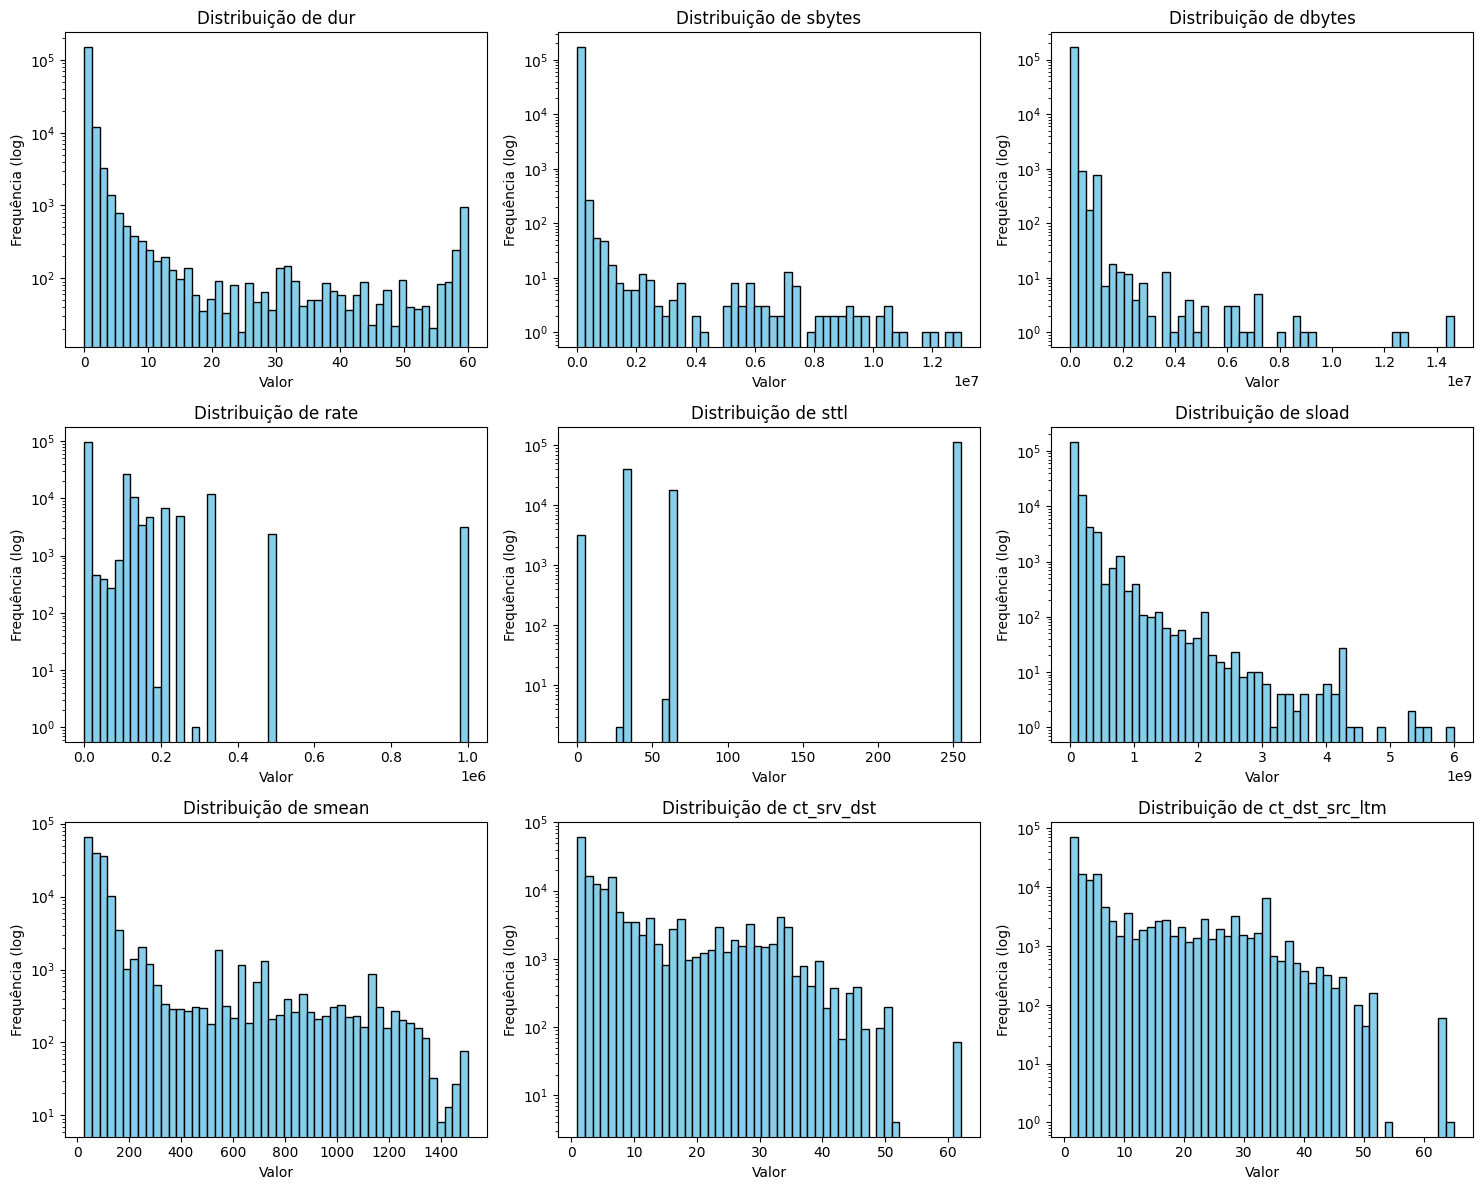

In [22]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(colunas_filter):
    ax = axes[i]

    ax.hist(df[col], bins=50, color='skyblue', edgecolor='black', log=True) # Facilitar a visualização (log)
    ax.set_title(f'Distribuição de {col}', fontsize=12)
    ax.set_xlabel('Valor')
    ax.set_ylabel('Frequência (log)')

for i in range(len(colunas_filter), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

### 5.2 Comparando a distribuição com base no tráfego

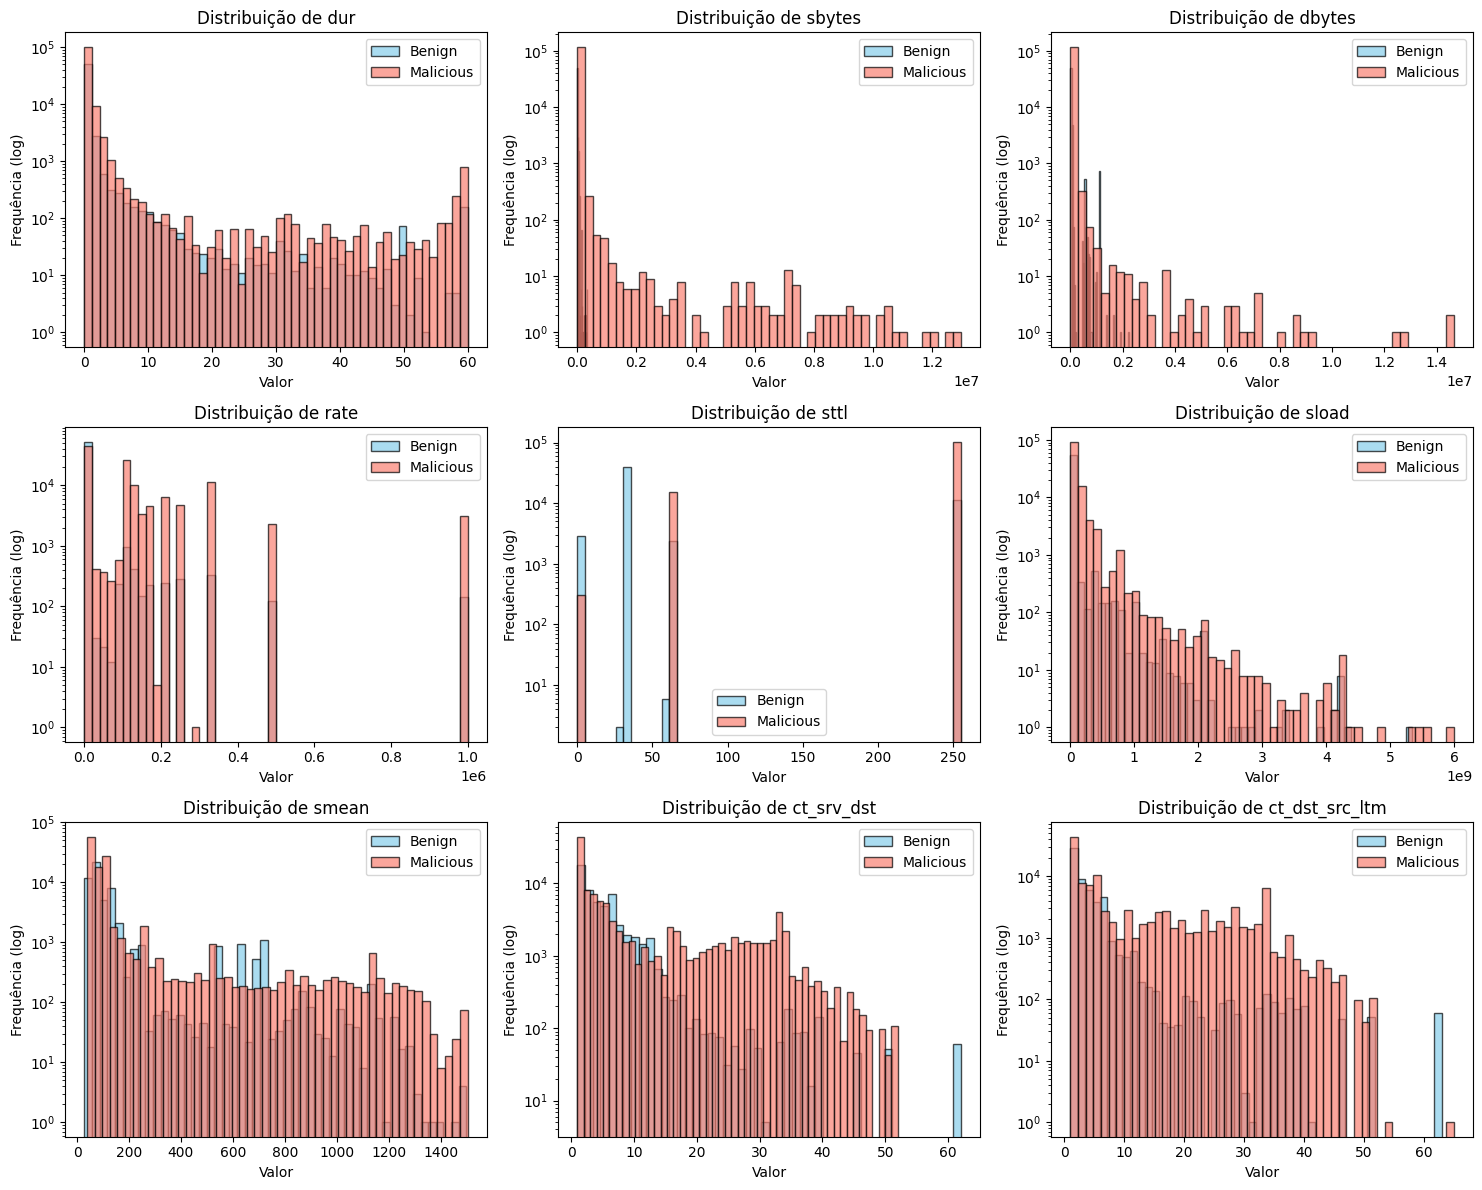

In [23]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(colunas_filter):
    ax = axes[i]

    dados_benign = df[df['label'] == 0][col]
    dados_maligno = df[df['label'] == 1][col]

    ax.hist(dados_benign,
            bins=50,
            color='skyblue',
            edgecolor='black',
            alpha=0.7,
            label='Benign',
            log=True
    )

    ax.hist(dados_maligno,
            bins=50,
            color='salmon',
            edgecolor='black',
            alpha=0.7,
            label='Malicious',
            log=True
    )

    ax.set_title(f'Distribuição de {col}', fontsize=12)
    ax.set_xlabel('Valor')
    ax.set_ylabel('Frequência (log)')
    ax.legend()
for i in range(len(colunas_filter), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

### 5.3 Pairplot

Devido ao grande volume de dados, rodar o pairplot tem um alto custo computacional. Para contornar essa situação se fez uma amostragem por dois motivos.

- Deixar os dados balanceados para uma melhor compreensão das suas diferenças
- Reduzir o custo computacional

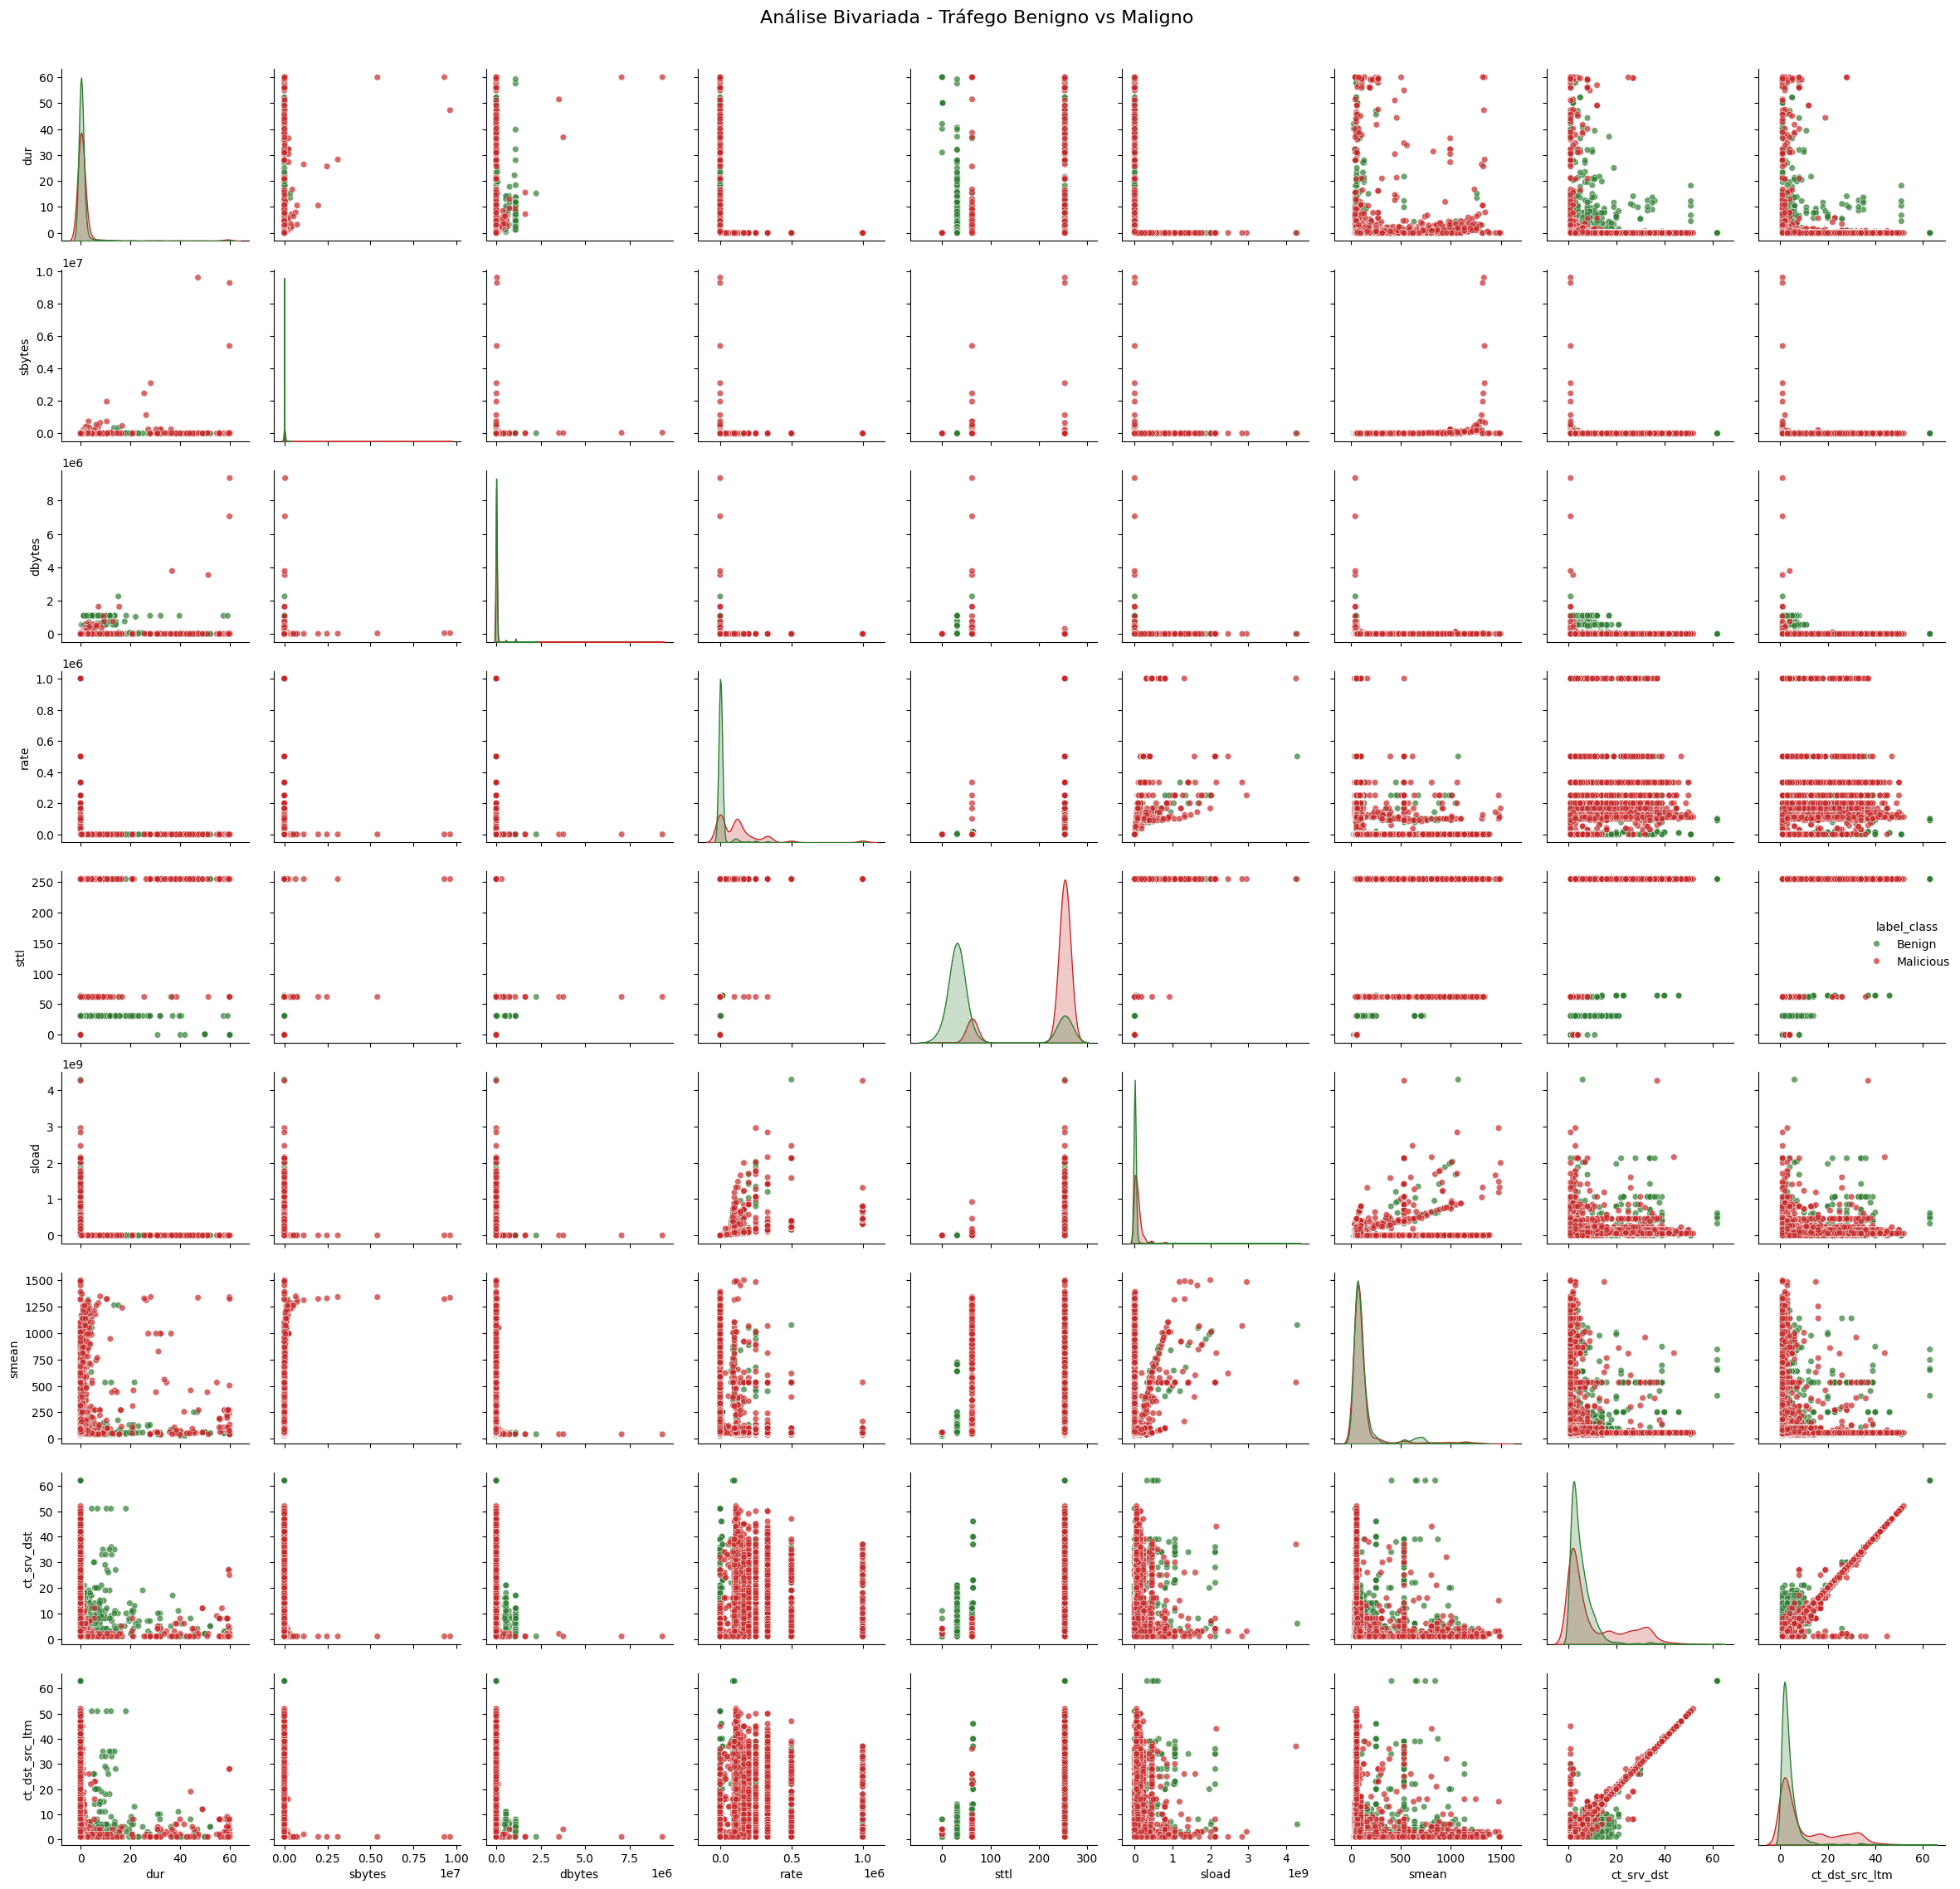

In [24]:
df_viz = df[colunas_filter].copy()
df_viz['label_class'] = df['label'].map({0: 'Benign', 1: 'Malicious'})

df_majority = df_viz[df_viz.label_class == 'Benign'].sample(5000, random_state=42)
df_minority = df_viz[df_viz.label_class == 'Malicious'].sample(min(5000, len(df_viz[df_viz.label_class == 'Malicious'])), random_state=42)
df_viz_balanced = pd.concat([df_majority, df_minority])

# sns.set_style("whitegrid")
g = sns.pairplot(df_viz_balanced,
                 hue='label_class',
                 palette={'Benign': '#2E7D32', 'Malicious': '#C62828'},
                 diag_kind='kde',
                 plot_kws={'alpha': 0.7, 's': 30},
                 height=2.5,
                 aspect=1)

g.fig.suptitle('Análise Bivariada - Tráfego Benigno vs Maligno', y=1.01, fontsize=16)
plt.tight_layout()
plt.show()

Quando olhamos esse nosso recorte de dados, conseguimos notar duas colunas que tendem a ter um padrão linear quando se trata de ataques. Sendo elas:
- ct_srv_dst x ct_dst_src_ltm e o inversos também (que já era esperado)

As demais não apresenta uma distribuição linear ou qualquer outro tipo que possa ser visto em um gráfico de duas dimensões.

### 5.4 Serviços e Protocolos mais utilizados pelo tráfego maligno

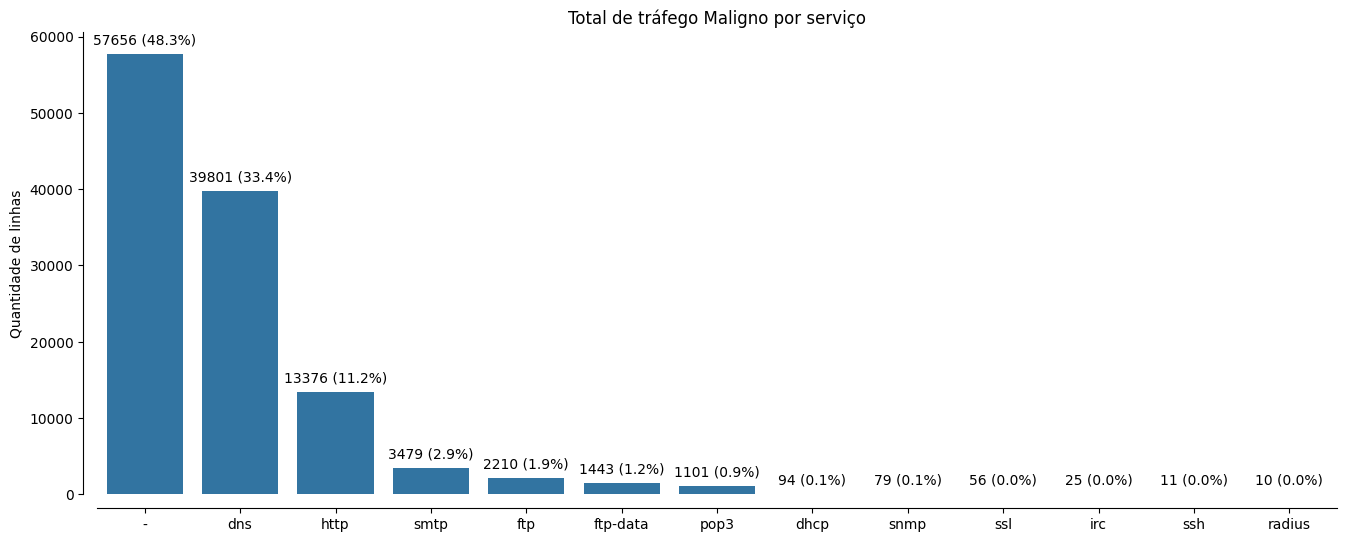

In [25]:
df_mal = df[df['label'] == 1].copy()
df_ben = df[df['label'] == 0].copy()

df_barplot = df_mal['service'].value_counts().to_frame().reset_index()

barplot(
    df_barplot,
    x='service',
    y='count',
    ylab="Quantidade de linhas",
    title="Total de tráfego Maligno por serviço",
    order_desc=True,
    figsize=(16, 6)
)

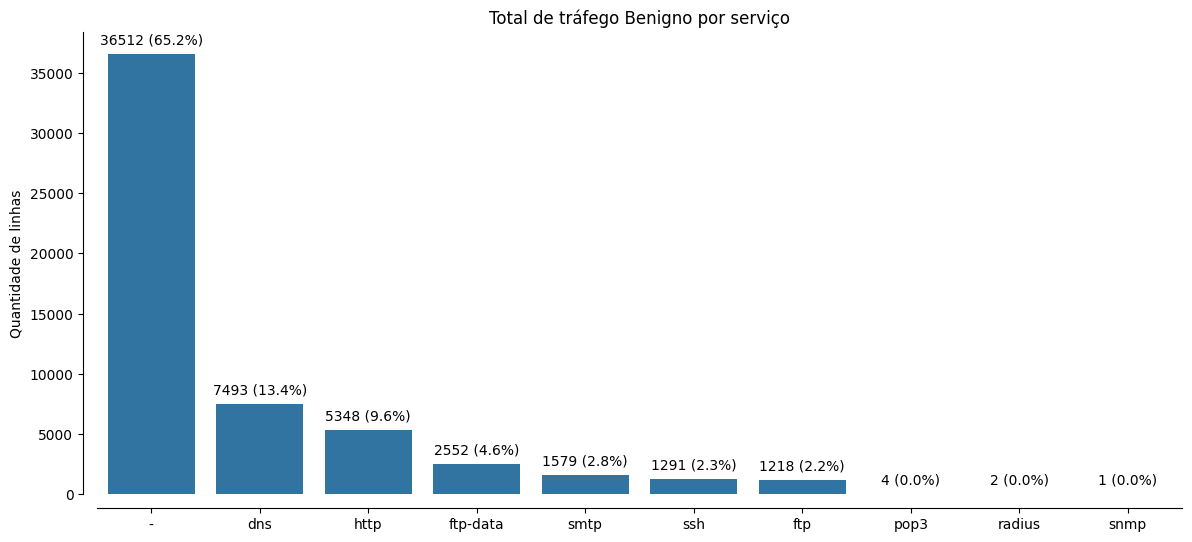

In [26]:
df_barplot = df_ben['service'].value_counts().to_frame().reset_index()

barplot(
    df_barplot,
    x='service',
    y='count',
    ylab="Quantidade de linhas",
    title="Total de tráfego Benigno por serviço",
    order_desc=True,
    figsize=(14, 6)
)

Quando olhamos para ambos conseguimos noatar que a classe `-` é mais usual para ambos os tráfegos, a mudança ocorre no segundo item, em qua o maligno usa `dns` e o beningo `http` e o terceiro item é o inverso. Também, conseguimos notar que o tráfego maligno tem algumas portas exclusivas como `ssl`, `itc`, etc.

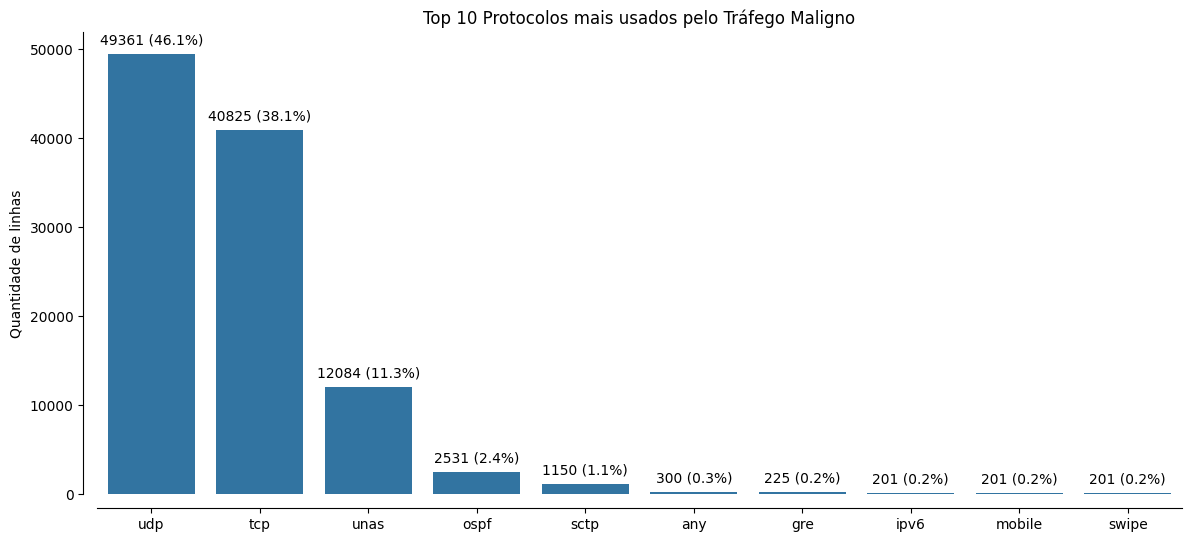

In [27]:
df_barplot = df_mal['proto'].value_counts().to_frame().reset_index().head(10)

barplot(
    df_barplot,
    x='proto',
    y='count',
    ylab="Quantidade de linhas",
    title="Top 10 Protocolos mais usados pelo Tráfego Maligno",
    order_desc=True,
    figsize=(14, 6)
)

In [28]:
df_mal['proto'].nunique()

129

Para esses protocolos aplicar uma tecnica de `Feature Lumping`.

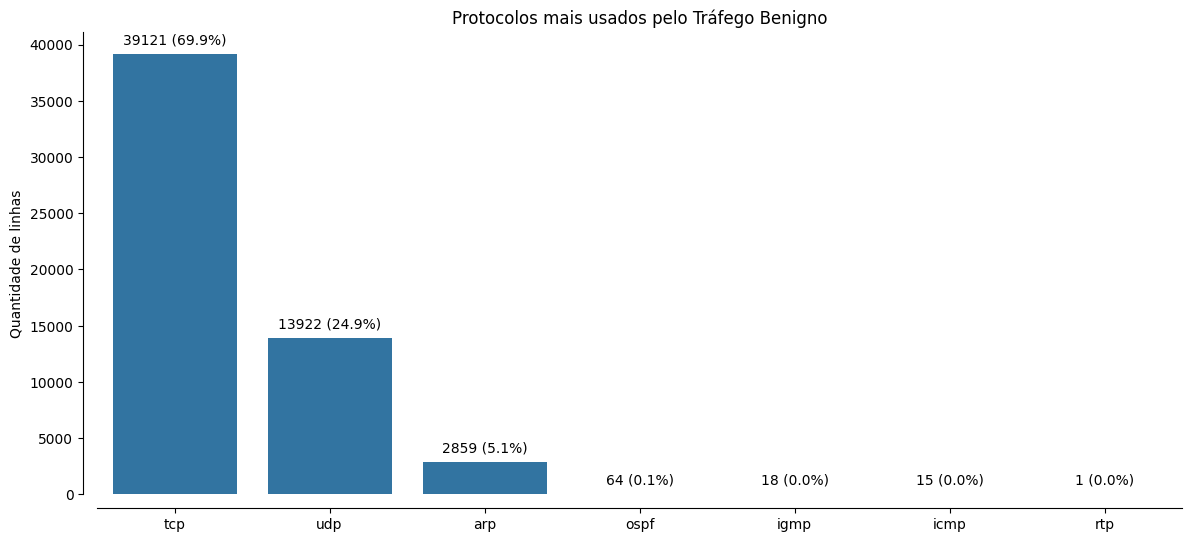

In [29]:
df_barplot = df_ben['proto'].value_counts().to_frame().reset_index()

barplot(
    df_barplot,
    x='proto',
    y='count',
    ylab="Quantidade de linhas",
    title="Protocolos mais usados pelo Tráfego Benigno",
    order_desc=True,
    figsize=(14, 6)
)

Quando olhamos para os gráfico conseguimos notar que o benigno se concentra bastante no TCP e UDP. O Maligno segue a lógica oposta e faz o uso de outros protocolos, além da presença do `unas`, que quer dizer que não foi atribuido algo a ele. Um ponto que vale ressaltar é que o benigno só está usando 5 protocolos, enquanto o maligno usa 129.

### 5.5 Os estados de conexão mais comuns quando olhamos os tráfego benigno e maligno

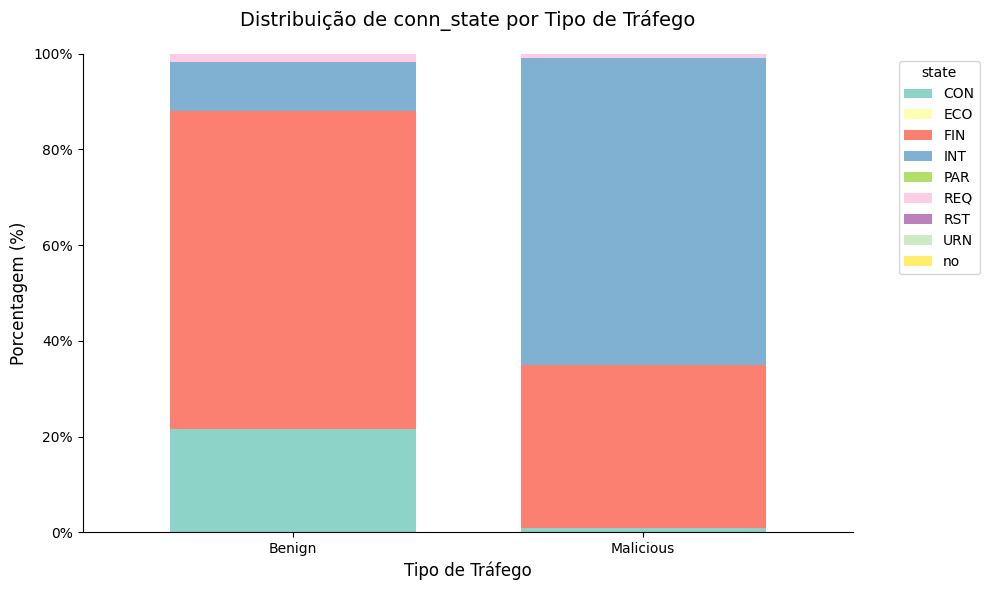

In [30]:
df['class_name'] = df['label'].map({0: 'Benign', 1: 'Malicious'})

plot_stacked_bar_100(
    df,
    coluna_1='class_name',
    coluna_2='state',
    xlab="Tipo de Tráfego",
    ylab="Porcentagem (%)",
    title="Distribuição de conn_state por Tipo de Tráfego"
)

plt.show()

In [31]:
crosstab = pd.crosstab(df['class_name'], df['state'])
crosstab_pct = crosstab.div(crosstab.sum(axis=1), axis=0) * 100
crosstab_pct

state            CON      ECO       FIN       INT      PAR      REQ      RST  \
class_name                                                                     
Benign     21.605357 0.021429 66.383929 10.205357 0.001786 1.651786 0.126786   
Malicious   0.882346 0.000000 34.062057 64.152303 0.000000 0.893239 0.010055   

state           URN       no  
class_name                    
Benign     0.001786 0.001786  
Malicious  0.000000 0.000000

É possível verificar que as conexões relevantes para os dados Malignos e Beningo são trocadas. Entretanto, mesmo sendo trocadas tem uma representatividade interessante, especialmente em `FIN`.

### 5.6 Correlações das variáveis numéricas

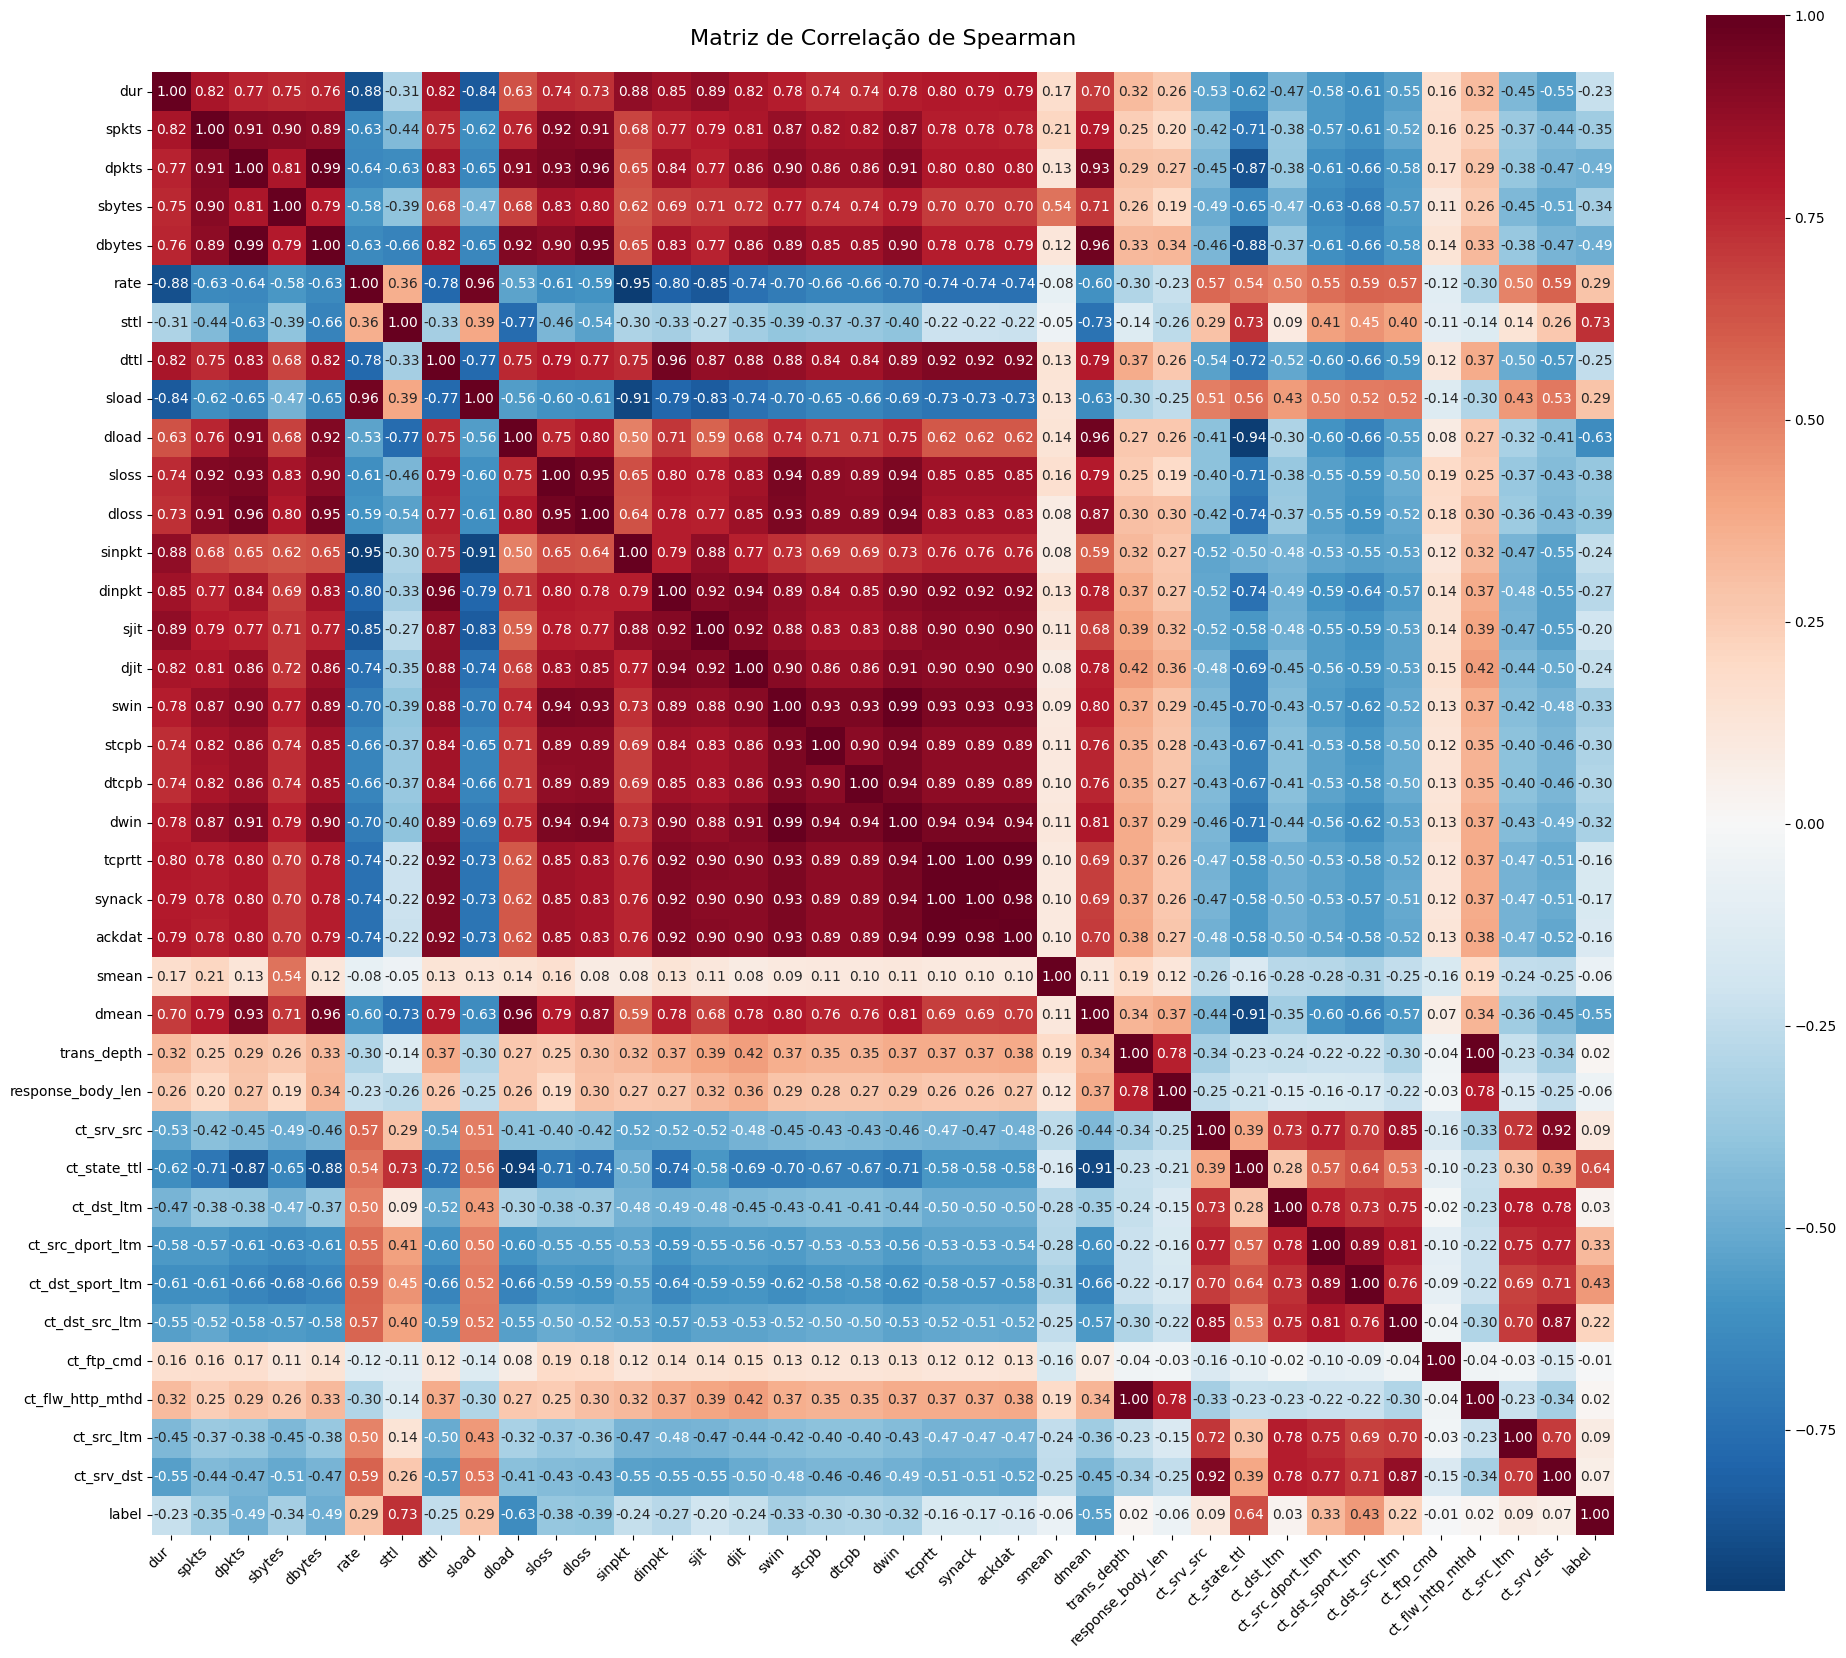

In [32]:
drop_corr = [
    'id', 'is_ftp_login', 'is_sm_ips_ports',
    'proto', 'service', 'state', 'attack_cat',
    'class_name'
]

correlation_matrix = df.drop(drop_corr, axis=1).corr(method='spearman')

plt.figure(figsize=(20, 20))

heatmap = sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='RdBu_r',
    center=0,
    square=True,
    fmt='.2f',
    cbar_kws={'shrink': 0.8},
    annot_kws={'size': 10}
)

plt.title('Matriz de Correlação de Spearman', fontsize=16, pad=20)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show();

Conseguimo verificar diversas variáveis correlacionadas entre sí. Um outro ponto é verificar que a variável que tem a correlação mais alta com a label é uma variável TTL, no caso a `sttl`, isso levanta o ponto se essas variáveis TTL não são uma forma de data leakage devido a criação dos dados em ambiente controlado. Nos artigos citados pelo autor se fez a remoção dessas colunas para conseguir uma melhor generalização dos dados.

Vamos deixar dois dataset preparados para a modelagem:
- Redução da dimensionalidade com o PCA
- Remoção de colunas com baixa correlação com a variável alvo e colunas altamente correlacionadas

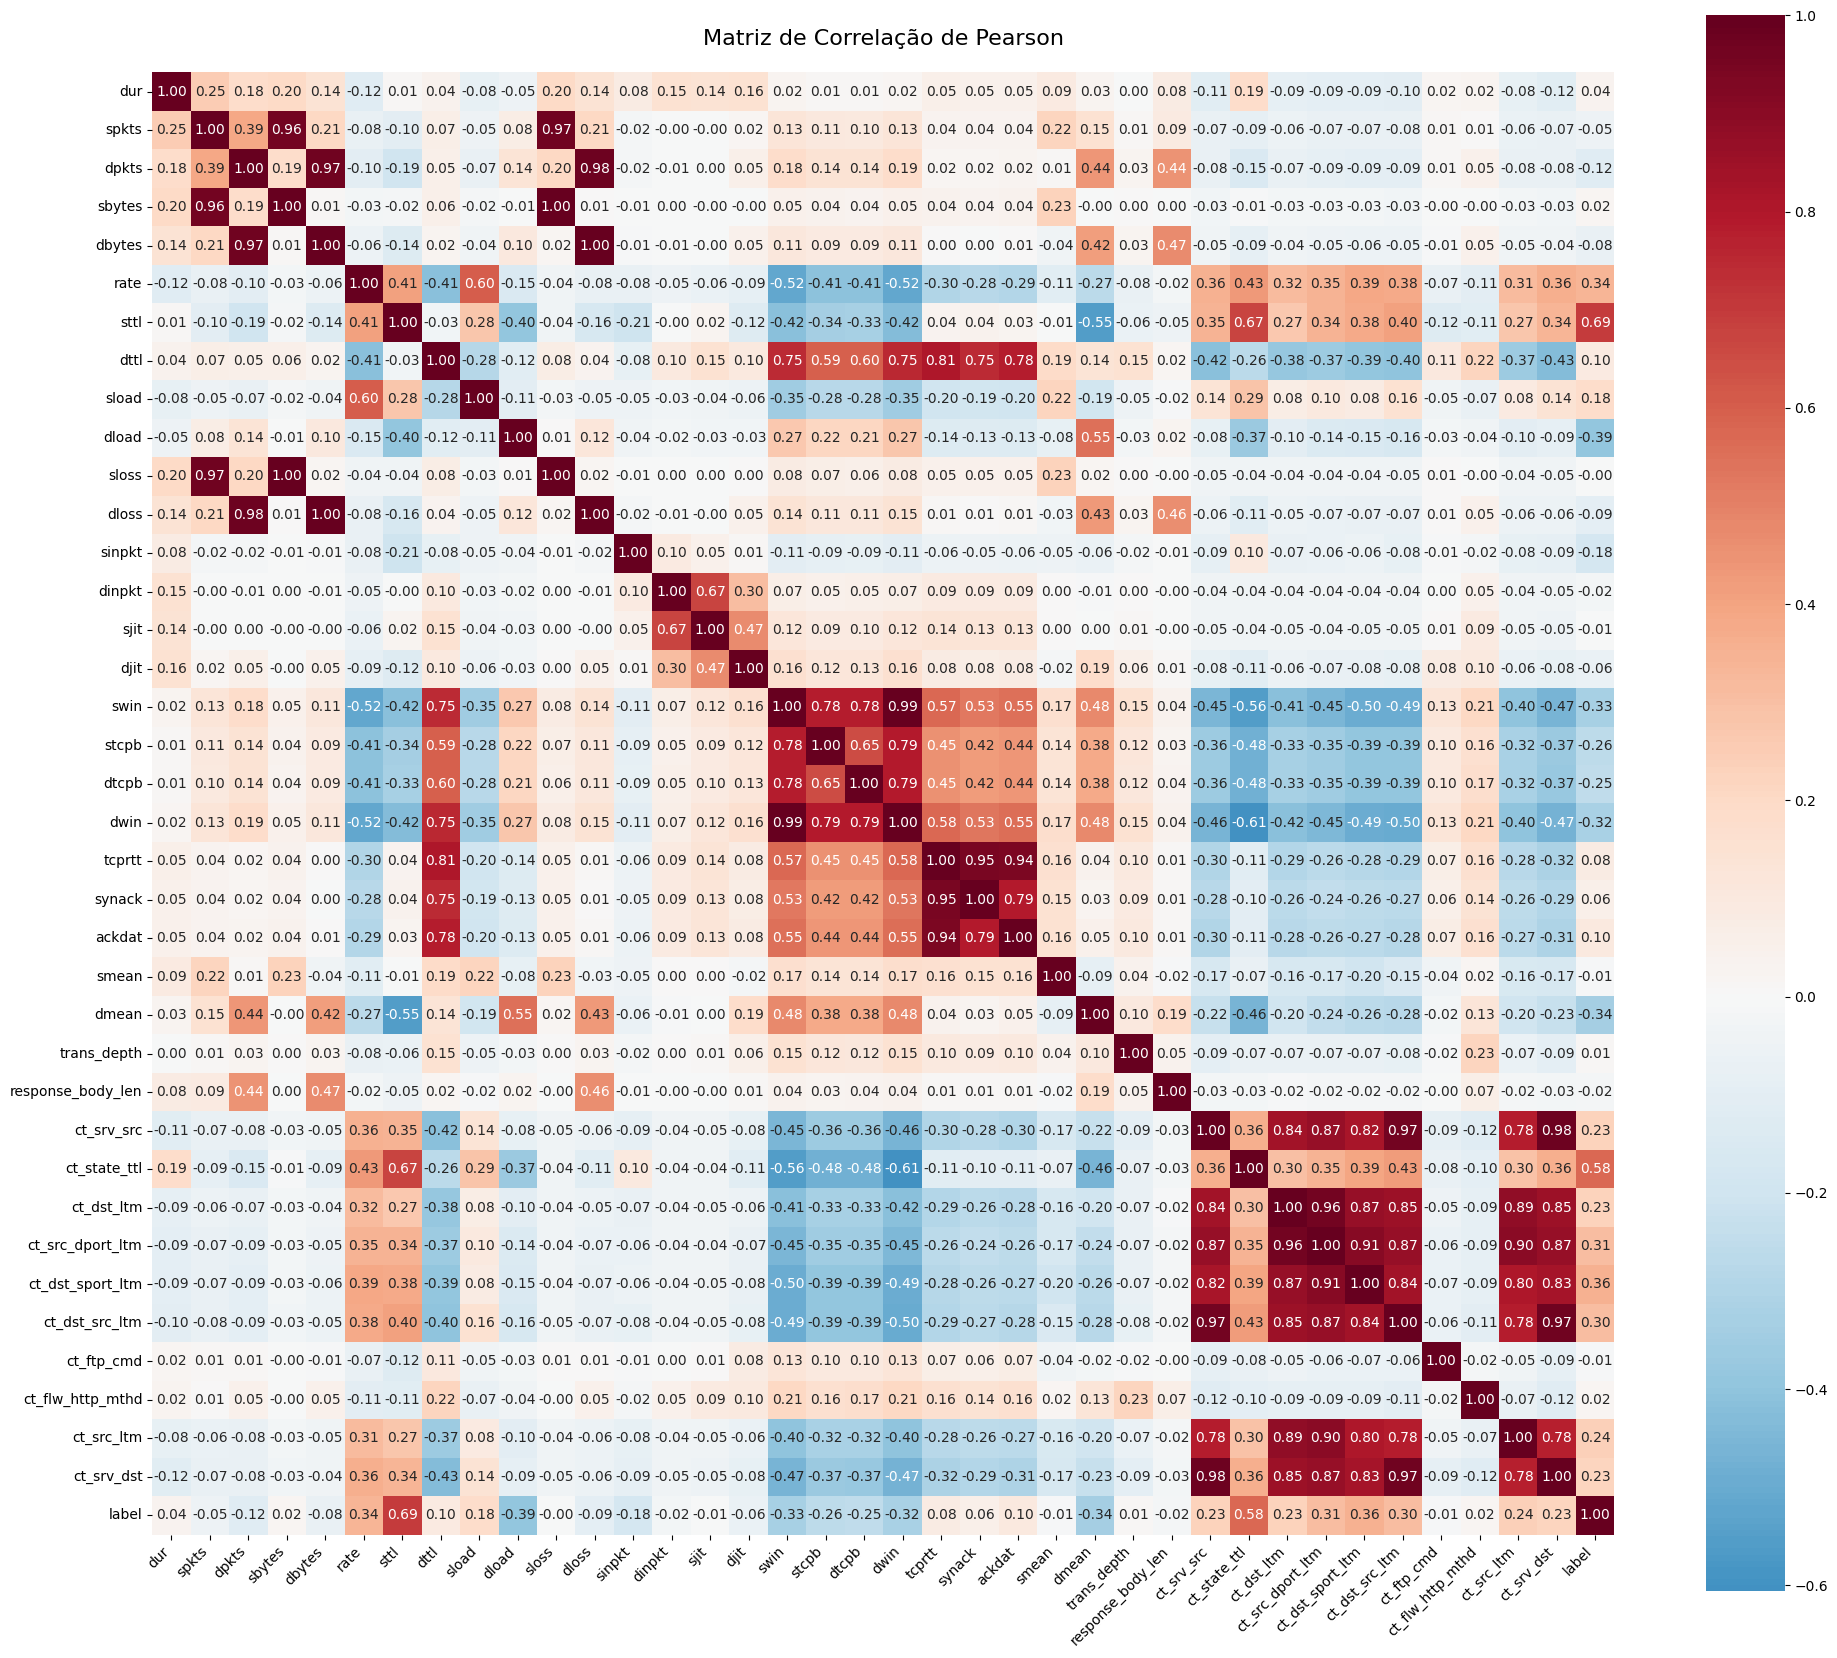

In [33]:
correlation_matrix = df.drop(drop_corr, axis=1).corr()

plt.figure(figsize=(20, 20))

heatmap = sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='RdBu_r',
    center=0,
    square=True,
    fmt='.2f',
    cbar_kws={'shrink': 0.8},
    annot_kws={'size': 10}
)

plt.title('Matriz de Correlação de Pearson', fontsize=16, pad=20)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show();

### 5.7 Análise de indenpências entre variáveis categoricas

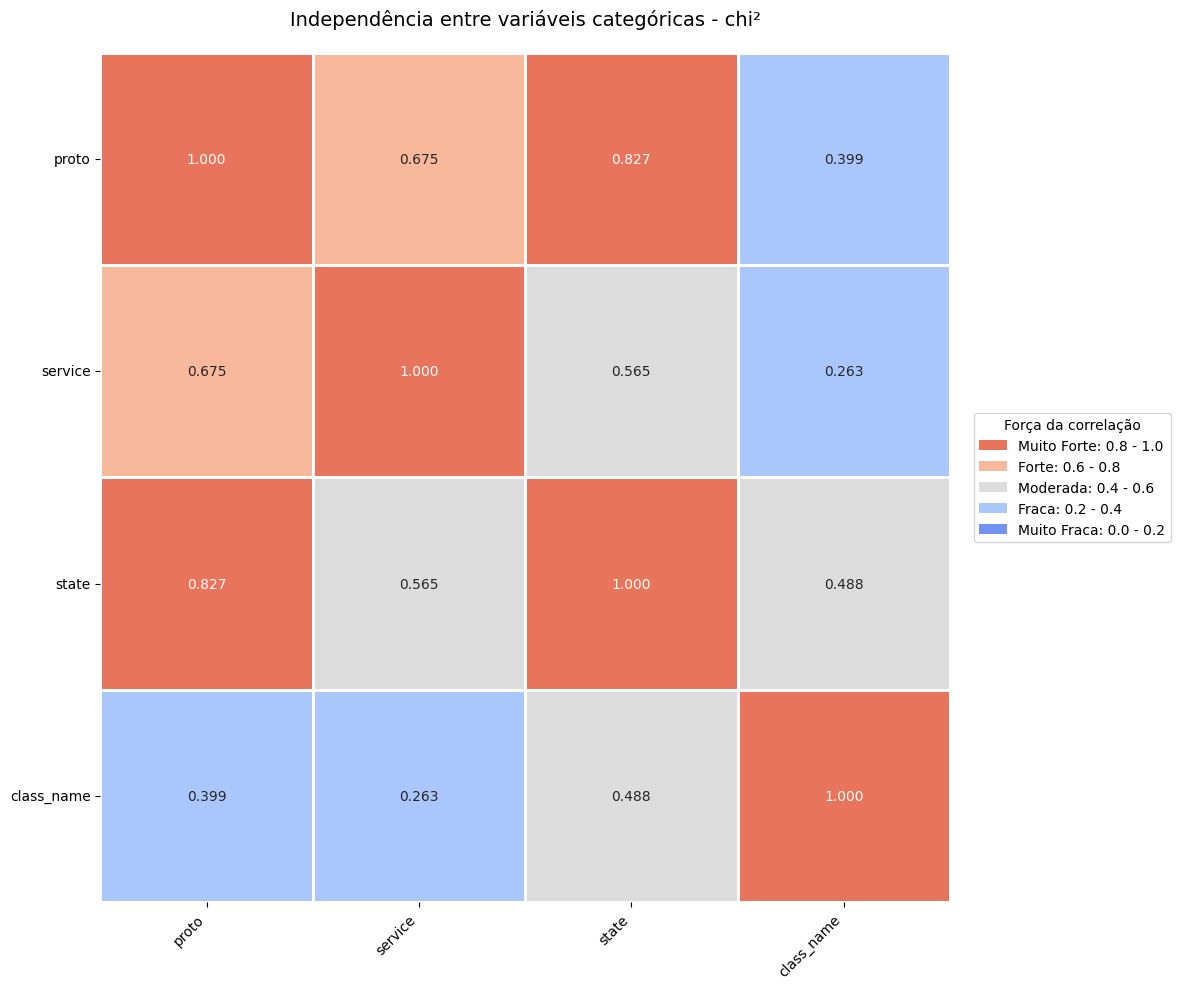

proto  service    state  class_name
proto      1.000000 0.675024 0.826739    0.398975
service    0.675024 1.000000 0.565246    0.262589
state      0.826739 0.565246 1.000000    0.487861
class_name 0.398975 0.262589 0.487861    1.000000

In [34]:
colunas_cat = ['proto', 'service', 'state', 'class_name']
plot_chi2_heatmap(df[colunas_cat], title="Independência entre variáveis categóricas - chi²")

Conseguimos notar que o estado e protocolo são as colunas com a maior relação com a nossa coluna alvo.

**Observações**:
- Como não fizemos nenhum tratamento de remoção de nulos ou transformações de colunas, vamos apenas utilizar o mesmo dataset para a modelagem, sem a necessidade de fazer importações do arquivo para Parquet ou algo do tipo.